In [ ]:
!pip install gymnasium

In [ ]:
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
###################################################################
###################################################################
#  ____    ____       _       _____  ____  _____
# |_   \  /   _|     / \     |_   _||_   \|_   _|
#   |   \/   |      / _ \      | |    |   \ | |
#   | |\  /| |     / ___ \     | |    | |\ \| |
#  _| |_\/_| |_  _/ /   \ \_  _| |_  _| |_\   |_
# |_____||_____||____|_|____||_____||_____|\____|____      ___   ____  _____  ____    ____  ________  ____  _____  _________
# |_   __  ||_   \|_   _||_  _| |_  _||_   _||_   __ \   .'   `.|_   \|_   _||_   \  /   _||_   __  ||_   \|_   _||  _   _  |
#   | |_ \_|  |   \ | |    \ \   / /    | |    | |__) | /  .-.  \ |   \ | |    |   \/   |    | |_ \_|  |   \ | |  |_/ | | \_|
#   |  _| _   | |\ \| |     \ \ / /     | |    |  __ /  | |   | | | |\ \| |    | |\  /| |    |  _| _   | |\ \| |      | |
#  _| |__/ | _| |_\   |_     \ ' /     _| |_  _| |  \ \_\  `-'  /_| |_\   |_  _| |_\/_| |_  _| |__/ | _| |_\   |_    _| |_
# |________||_____|\____|__  _\_/__   |_____||____| |___|`.___.'|_____|\____||_____||_____||________||_____|\____|  |_____|
#      / \     |_   \|_   _||_   _ `.
#     / _ \      |   \ | |    | | `. \
#    / ___ \     | |\ \| |    | |  | |
#  _/ /   \ \_  _| |_\   |_  _| |_.' /
# |____|_|____||_____|\____||______.'  _____  ____  _____  _____  ____  _____   ______
# |  _   _  ||_   __ \        / \     |_   _||_   \|_   _||_   _||_   \|_   _|.' ___  |
# |_/ | | \_|  | |__) |      / _ \      | |    |   \ | |    | |    |   \ | | / .'   \_|
#     | |      |  __ /      / ___ \     | |    | |\ \| |    | |    | |\ \| | | |   ____
#    _| |_    _| |  \ \_  _/ /   \ \_  _| |_  _| |_\   |_  _| |_  _| |_\   |_\ `.___]  |
#   |_____|  |____|_|___||____|_|____||_____||_____|\____||_____||_____|\____|`._____.'
#      / \     |_   \|_   _||_   _ `.
#     / _ \      |   \ | |    | | `. \
#    / ___ \     | |\ \| |    | |  | |
#  _/ /   \ \_  _| |_\   |_  _| |_.' /
# |____| |____||_____|\____||______.'
#  ________  ____  ____  _______  ________  _______     _____  ____    ____  ________  ____  _____  _________   ______
# |_   __  ||_  _||_  _||_   __ \|_   __  ||_   __ \   |_   _||_   \  /   _||_   __  ||_   \|_   _||  _   _  |.' ____ \
#   | |_ \_|  \ \  / /    | |__) | | |_ \_|  | |__) |    | |    |   \/   |    | |_ \_|  |   \ | |  |_/ | | \_|| (___ \_|
#   |  _| _    > `' <     |  ___/  |  _| _   |  __ /     | |    | |\  /| |    |  _| _   | |\ \| |      | |     _.____`.
#  _| |__/ | _/ /'`\ \_  _| |_    _| |__/ | _| |  \ \_  _| |_  _| |_\/_| |_  _| |__/ | _| |_\   |_    _| |_   | \____) |
# |________||____||____||_____|  |________||____| |___||_____||_____||_____||________||_____|\____|  |_____|   \______.'
###################################################################
###################################################################


import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import random
from typing import List, Dict, Tuple, Any, Optional
import pandas as pd
from tqdm import tqdm
import os
import itertools
import pickle
import scipy.stats as stats
import seaborn as sns

# Set global parameters for reproducibility
RANDOM_SEED = 42

# TODO: Maybe make this configurable via command line args?

# 20 Mar 2025 - Added this function to fix the scipy issue
# This is a hacky workaround for the scipy.stats.binom_test deprecation
# I spent like 3 hours trying to figure out why my tests were failing...
def fix_binom_test_function():
    """
    Replaces stats.binom_test with the current scipy implementation.
    """
    import scipy.stats as stats

    # Define a replacement function that matches the old API but uses the new implementation
    def binom_test_replacement(x, n=None, p=0.5, alternative='two-sided'):
        # Handle the case where only x is provided (assumed to be for a binary test)
        if n is None:
            n =x
            x =1  # Default behavior for binary test

        # Use the new binomtest function
        result =stats.binomtest(x, n, p, alternative)
        return result.pvalue

    # Add the replacement function to the stats module
    stats.binom_test =binom_test_replacement

    print("Fixed scipy.stats.binom_test compatibility issue")

## 21 Mar 2025 - Added this function
# Run this function before importing or executing any other code
fix_binom_test_function()

class Mancala4PlayerEnv(gym.Env):
    """
    4-player Mancala environment implementing the Gymnasium interface.

    Rules:
    - Each player has N pits with M stones each
    - Captures occur when last stone lands in empty pit on player's side
    - Extra turn when last stone lands in player's store
    - Game ends when any player's pits are empty
    """

    def __init__(self, pits_per_player=6, initial_stones=4):
        super().__init__()

        # Game parameters
        self.pits_per_player= pits_per_player
        self.initial_stones =initial_stones
        self.num_players =4 # hardcoded for now, could make this flexible in future...
        self.board_size= (self.pits_per_player + 1) * self.num_players

        # Spaces
        self.action_space = spaces.Discrete(self.pits_per_player)
        max_stones = self.initial_stones * self.pits_per_player * self.num_players
        self.observation_space = spaces.Box(
            low=0, high=max_stones,
            shape=(self.board_size,), dtype=np.int32
        )

        # Store indices for each player
        self.stores = {
            i: (i * (self.pits_per_player + 1) - 1)
            for i in range(1, self.num_players + 1)
        }

        # Create opposite pit mappings for captures
        self.opposite_pits = self._create_opposite_pits()

    def _create_opposite_pits(self) -> Dict[int, int]:
        """Creates mapping of pits to their opposite pits for captures"""
        opposite_pits = {}
        for player in range(self.num_players):
            start = player * (self.pits_per_player + 1)
            opposite_player = (player + 2) % self.num_players
            opposite_start = opposite_player * (self.pits_per_player + 1)

            for i in range(self.pits_per_player):
                opposite_pits[start + i] = opposite_start + i

        return opposite_pits

    def get_player_pits(self, player: int) -> range:
        """Returns range of pit indices for given player"""
        start = (player - 1) * (self.pits_per_player + 1)
        return range(start, start + self.pits_per_player)

    def get_valid_actions(self, player: int) -> List[int]:
        """Returns list of valid actions (non-empty pits) for given player"""
        return [i for i in range(self.pits_per_player)
                if self.board[((player - 1) * (self.pits_per_player + 1)) + i] > 0]

    def reset(self, seed=None):
        """Resets the environment to initial state"""
        super().reset(seed=seed)
        self.board = np.array([self.initial_stones] * self.board_size)
        for store in self.stores.values():
            self.board[store] = 0
        self.current_player = 1
        return self.board.copy(), {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """
        Executes one step in the environment:
        1. Validates action
        2. Moves stones
        3. Handles captures
        4. Checks game end
        5. Updates current player
        """
        if action not in self.get_valid_actions(self.current_player):
            raise ValueError(f"Invalid action {action} for player {self.current_player}")

        # Move stones
        pit = ((self.current_player - 1) * (self.pits_per_player + 1)) + action
        stones = self.board[pit]
        self.board[pit] = 0
        current_pit = pit

        info = {
            'stones_captured': 0,  # Stones captured from opponents
            'stones_to_store': 0,  # Stones moved to store through normal play
            'total_stones_gained': 0,  # Total stones gained this turn
            'extra_turn': False,
            'landing_pit': -1
        }

        # Distribute stones
        while stones > 0:
            current_pit = (current_pit + 1) % self.board_size
            if current_pit in self.stores.values():
                if current_pit != self.stores[self.current_player]:
                    continue
                info['stones_to_store'] += 1
            self.board[current_pit] += 1
            stones -= 1

        info['landing_pit'] = current_pit

        # Calculate rewards
        reward = self._calculate_reward(current_pit, info)

        # Check game end
        game_over = self._check_game_over()
        if game_over:
            final_reward, end_stones = self._handle_game_end()
            info['stones_to_store'] += end_stones
            reward += final_reward

        # Update total stones gained
        info['total_stones_gained'] = info['stones_captured'] + info['stones_to_store']

        # Update current player
        if not game_over and not info['extra_turn']:
            self.current_player = (self.current_player % self.num_players) + 1

        return self.board.copy(), reward, game_over, False, info

    def _calculate_reward(self, landing_pit: int, info: Dict) -> float:
        """Calculates reward for the current move"""
        reward = 0

        # Reward for getting stones in store
        if info['stones_to_store'] > 0:
            reward += 0.5 * info['stones_to_store']

        # Handle captures
        if (landing_pit in self.get_player_pits(self.current_player) and
            self.board[landing_pit] == 1):
            opposite_pit = self.opposite_pits.get(landing_pit)
            if opposite_pit is not None and self.board[opposite_pit] > 0:
                captured = self.board[opposite_pit] + self.board[landing_pit]
                self.board[self.stores[self.current_player]] += captured
                self.board[landing_pit] = 0
                self.board[opposite_pit] = 0
                info['stones_captured'] = captured
                reward += 2.0 * captured  # Higher reward for captures

        # Extra turn bonus
        if landing_pit == self.stores[self.current_player]:
            info['extra_turn'] = True
            reward += 3.0  # Bonus for extra turn, see if this can be improved
            # hardcoded for now
            #TODO can this bonus be made into a decreasing function as the game reaches the end?...

        return reward

    def _check_game_over(self) -> bool:
        """Checks if any player has no stones in their pits"""
        return any(
            sum(self.board[list(self.get_player_pits(p))]) == 0
            for p in range(1, self.num_players + 1)
        )

    def _handle_game_end(self) -> Tuple[float, int]:
        """Handles end of game and returns final reward and stones moved to store"""
        # Move remaining stones to stores
        stones_moved = 0
        for player in range(1, self.num_players + 1):
            pits = list(self.get_player_pits(player))
            stones = sum(self.board[pits])
            self.board[self.stores[player]] += stones
            if player == self.current_player:
                stones_moved += stones
            self.board[pits] = 0

        # Calculate final reward
        scores = [self.board[store] for store in self.stores.values()]
        current_score = self.board[self.stores[self.current_player]]

        reward = 0
        if current_score == max(scores):  # Win
            reward += 25.0 # TODO experiment with win reward
        elif current_score >= sum(scores) / len(scores):  # Above average
            reward += 10.0

        return reward + stones_moved * 0.5, stones_moved


class ReplayBuffer:
    """Experience replay buffer for improved learning"""

    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, valid_actions, valid_next_actions):
        self.buffer.append((state, action, reward, next_state, valid_actions, valid_next_actions))

    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))

    def __len__(self):
        return len(self.buffer)


class MancalaAgent:
    """Q-learning agent with experience replay"""

    def __init__(self, learning_rate=0.1, discount_factor=0.95,
                 exploration_rate=1.0, min_exploration_rate=0.01,
                 exploration_decay=0.9995):
        # Mar 11 2025 -> Tried to use a defaultdict along with lambda and failed, need to improve
        # Mar 12 2025 -> Used a reglar dict instead of defaultdict with lambda
        self.q_table = {}
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay = exploration_decay

        # Experience replay
        self.replay_buffer = ReplayBuffer()
        self.batch_size = 32 # hardcoded for now, could make this flexible in future

        # Metrics
        self.episode_rewards = []
        self.wins = 0
        self.games_played = 0
        self.stones_captured = []
        self.total_stones_gained = []
        self.extra_turns = 0

    def choose_action(self, state, valid_actions: List[int]) -> int:
        """Chooses action using epsilon-greedy policy"""
        if not valid_actions:
            raise ValueError("No valid actions available")

        state_key = tuple(state)

        # Initialize Q-values for new state-action pairs
        if state_key not in self.q_table:
            self.q_table[state_key] = {
                action: np.random.uniform(0.1, 0.5)
                for action in valid_actions
            }

        # Ensure all valid actions have Q-values
        for action in valid_actions:
            if action not in self.q_table[state_key]:
                self.q_table[state_key][action] = np.random.uniform(0.1, 0.5)

        # Epsilon-greedy action selection
        if random.random() < self.exploration_rate:
            return random.choice(valid_actions)

        # Choose best action, breaking ties randomly
        max_q = max(self.q_table[state_key][a] for a in valid_actions)
        best_actions = [a for a in valid_actions
                       if self.q_table[state_key][a] == max_q]
        return random.choice(best_actions)

    def learn(self, state, action, reward, next_state, valid_actions, valid_next_actions):
        """Updates Q-values using experience replay"""
        self.replay_buffer.add(state, action, reward, next_state,
                             valid_actions, valid_next_actions)

        if len(self.replay_buffer) >= self.batch_size:
            self._experience_replay()

    def _experience_replay(self):
        """Performs experience replay update"""
        batch = self.replay_buffer.sample(self.batch_size)

        for (state, action, reward, next_state,
             valid_actions, valid_next_actions) in batch:
            state_key = tuple(state)
            next_state_key = tuple(next_state)

            # Calculate target Q-value
            if valid_next_actions:
                # Make sure Q-values exist for all valid next actions
                if next_state_key not in self.q_table:
                    self.q_table[next_state_key] = {}

                # Initialize any missing Q-values for valid next actions
                for next_action in valid_next_actions:
                    if next_action not in self.q_table[next_state_key]:
                        self.q_table[next_state_key][next_action] = np.random.uniform(0.1, 0.5)

                # Now safely compute max Q-value
                max_next_q = max(self.q_table[next_state_key][a] for a in valid_next_actions)
            else:
                max_next_q = 0


            if state_key not in self.q_table:
                self.q_table[state_key] = {}
            if action not in self.q_table[state_key]:
                self.q_table[state_key][action] = np.random.uniform(0.1, 0.5)


            current_q = self.q_table[state_key][action]
            new_q = current_q + self.learning_rate * (
                reward + self.discount_factor * max_next_q - current_q
            )
            self.q_table[state_key][action] = new_q

    def update_metrics(self, episode_reward, won=False, stones_captured=0, total_stones_gained=0):
        """Updates agent's performance metrics"""
        self.episode_rewards.append(episode_reward)
        self.stones_captured.append(stones_captured)
        self.total_stones_gained.append(total_stones_gained)
        self.games_played += 1
        if won:
            self.wins += 1

    def decay_exploration(self):
        """Decays exploration rate"""
        self.exploration_rate = max(
            self.min_exploration_rate,
            self.exploration_rate * self.exploration_decay
        )


class RandomAgent:
    """Random agent for evaluation"""

    def choose_action(self, state, valid_actions):
        if not valid_actions:
            raise ValueError("No valid actions available")
        return random.choice(valid_actions)

#TRAININGTIMEPARAMETER
def train_agents(env, num_episodes=10000, verbose=True): #train for 10000 episodes, this is already overridden to 3000 episodes
    """Trains multiple agents in the environment"""
    agents = [MancalaAgent() for _ in range(4)]

    metrics = {
        'episode_rewards': [[] for _ in range(4)],
        'win_rates': [[] for _ in range(4)],
        'stones_captured': [[] for _ in range(4)],
        'total_stones_gained': [[] for _ in range(4)],
        'extra_turns': [0] * 4
    }

    # Training loop with progress bar
    progress_bar = tqdm(range(num_episodes), desc="Training") if verbose else range(num_episodes)
    for episode in progress_bar:
        state, _ = env.reset()
        done = False
        episode_rewards = [0] * 4
        episode_captures = [0] * 4
        episode_total_stones = [0] * 4

        while not done:
            current_player = env.current_player - 1
            valid_actions = env.get_valid_actions(env.current_player)
            if not valid_actions: #TODO: Redundant?...
                break

            action = agents[current_player].choose_action(
                tuple(state), valid_actions
            )
            next_state, reward, done, _, info = env.step(action)

            # Track metrics
            episode_captures[current_player] += info['stones_captured']
            episode_total_stones[current_player] += info['total_stones_gained']
            if info.get('extra_turn', False):
                metrics['extra_turns'][current_player] += 1

            if not done:
                next_valid_actions = env.get_valid_actions(env.current_player)
                agents[current_player].learn(
                    tuple(state), action, reward, tuple(next_state),
                    valid_actions, next_valid_actions
                )

            episode_rewards[current_player] += reward
            state = next_state

        # Update metrics
        scores = [env.board[store] for store in env.stores.values()]
        winner = scores.index(max(scores))

        for i, (agent, reward) in enumerate(zip(agents, episode_rewards)):
            agent.update_metrics(
                reward,
                won=(i == winner),
                stones_captured=episode_captures[i],
                total_stones_gained=episode_total_stones[i]
            )
            agent.decay_exploration()

            metrics['episode_rewards'][i].append(reward)
            metrics['win_rates'][i].append(agent.wins / (episode + 1))
            metrics['stones_captured'][i].append(episode_captures[i])
            metrics['total_stones_gained'][i].append(episode_total_stones[i])

        # 20 Mar 2025 -> Added this progress printer function for verbose
        # Print progress every 500 episodes
        #TODO Make progress more comprehensive
        if verbose and (episode + 1) % 500 == 0:
            win_rates = [agent.wins / (episode + 1) for agent in agents]
            avg_captures = [np.mean(metrics['stones_captured'][i][-100:]) for i in range(4)]
            avg_total_stones = [np.mean(metrics['total_stones_gained'][i][-100:]) for i in range(4)]

            print(f"\nEpisode {episode + 1}/{num_episodes}")
            print(f"Win rates: {[f'{rate:.2%}' for rate in win_rates]}")
            print(f"Recent captures: {[f'{cap:.1f}' for cap in avg_captures]}")
            print(f"Recent total stones: {[f'{stones:.1f}' for stones in avg_total_stones]}")
            print(f"Exploration rates: {[f'{agent.exploration_rate:.2%}' for agent in agents]}")

    return agents, metrics


def evaluate_against_random(env, trained_agent, num_games=1000, verbose=True):
    """Evaluates trained agent against random agents"""
    random_agents = [RandomAgent() for _ in range(3)]

    metrics = {
        'trained_agent_wins': 0,
        'trained_agent_scores': [],
        'random_scores': [[] for _ in range(3)],
        'stones_captured': [],
        'total_stones_gained': [],
        'extra_turns': 0,
        'game_durations': []
    }

    progress_bar = tqdm(range(num_games), desc="Evaluating") if verbose else range(num_games)
    for game in progress_bar:
        state, _ = env.reset()
        done = False
        game_captures = 0
        game_total_stones = 0
        game_steps = 0

        while not done:
            game_steps += 1
            current_player = env.current_player - 1
            valid_actions = env.get_valid_actions(env.current_player)

           #TODO Remove since this is redundant, it should never reach this area....
            if not valid_actions:
                break

            if current_player == 0:  # Trained agent's turn
                action = trained_agent.choose_action(tuple(state), valid_actions)
            else:  # Random agent's turn
                action = random_agents[current_player - 1].choose_action(state, valid_actions)

            state, _, done, _, info = env.step(action)

            if current_player == 0:  # Track trained agent's performance
                game_captures += info['stones_captured']
                game_total_stones += info['total_stones_gained']
                if info.get('extra_turn', False):
                    metrics['extra_turns'] += 1

        # Record game results
        metrics['game_durations'].append(game_steps)
        scores = [env.board[store] for store in env.stores.values()]
        metrics['trained_agent_scores'].append(scores[0])
        for i in range(3):
            metrics['random_scores'][i].append(scores[i + 1])

        if scores[0] == max(scores):
            metrics['trained_agent_wins'] += 1

        metrics['stones_captured'].append(game_captures)
        metrics['total_stones_gained'].append(game_total_stones)

    # Calculate summary statistics
    metrics['win_rate'] = metrics['trained_agent_wins'] / num_games
    metrics['avg_score'] = np.mean(metrics['trained_agent_scores'])
    metrics['avg_random_scores'] = [np.mean(scores) for scores in metrics['random_scores']]
    metrics['avg_stones_captured'] = np.mean(metrics['stones_captured'])
    metrics['avg_total_stones_gained'] = np.mean(metrics['total_stones_gained'])
    metrics['avg_extra_turns'] = metrics['extra_turns'] / num_games
    metrics['avg_game_duration'] = np.mean(metrics['game_durations'])

    # Calculate standard deviations for statistical analysis
    metrics['std_score'] = np.std(metrics['trained_agent_scores'])
    metrics['std_random_scores'] = [np.std(scores) for scores in metrics['random_scores']]
    metrics['std_stones_captured'] = np.std(metrics['stones_captured'])
    metrics['std_total_stones_gained'] = np.std(metrics['total_stones_gained'])
    metrics['std_game_duration'] = np.std(metrics['game_durations'])

    # Calculate confidence intervals (95%)
    n = num_games
    metrics['ci_score'] = 1.96 * metrics['std_score'] / np.sqrt(n)
    metrics['ci_random_scores'] = [1.96 * std / np.sqrt(n) for std in metrics['std_random_scores']]
    metrics['ci_stones_captured'] = 1.96 * metrics['std_stones_captured'] / np.sqrt(n)
    metrics['ci_total_stones_gained'] = 1.96 * metrics['std_total_stones_gained'] / np.sqrt(n)
    metrics['ci_game_duration'] = 1.96 * metrics['std_game_duration'] / np.sqrt(n)

    # Calculate statistical significance (p-value) for win rate compared to random chance (25%)
    # Using stats.binomtest (function name corrected)
    metrics['win_rate_p_value'] = stats.binomtest( # previously binom_test
        metrics['trained_agent_wins'], n=num_games, p=0.25, alternative='greater'
    )

    # Calculate statistical significance for score difference
    for i in range(3):
        t_stat, p_val = stats.ttest_ind(
            metrics['trained_agent_scores'],
            metrics['random_scores'][i],
            equal_var=False  # Welch's t-test
        )
        metrics[f'score_diff_p_value_{i+1}'] = p_val

    return metrics


def train_and_evaluate(pits_per_player, initial_stones, train_episodes=10000, eval_games=500, verbose=True): #TRAININGPARAMETER
    """
    Trains agents for a specific configuration and evaluates the best agent.

    Args:
        pits_per_player: Number of pits per player
        initial_stones: Number of initial stones per pit
        train_episodes: Number of episodes for training
        eval_games: Number of games for evaluation against random agents
        verbose: Whether to print progress updates

    Returns:
        Dictionary containing training and evaluation metrics
    """
    # Initialize environment with specific parameters
    env = Mancala4PlayerEnv(pits_per_player=pits_per_player,
                          initial_stones=initial_stones)

    # Make directory for results if it doesn't exist
    os.makedirs("mancala_results", exist_ok=True)

    # Train agents
    if verbose:
        print(f"\nTraining with pits={pits_per_player}, stones={initial_stones}...")

    trained_agents, training_metrics = train_agents(env, num_episodes=train_episodes, verbose=verbose)

    # Find best agent
    win_rates = [agent.wins / agent.games_played for agent in trained_agents]
    best_agent_idx = win_rates.index(max(win_rates))
    best_agent = trained_agents[best_agent_idx]

    # Evaluate best agent
    if verbose:
        print(f"\nEvaluating best agent (Player {best_agent_idx+1})...")

    eval_metrics = evaluate_against_random(env, best_agent, num_games=eval_games, verbose=verbose)

    # Package all metrics
    results = {
        'pits': pits_per_player,
        'stones': initial_stones,
        'training_metrics': training_metrics,
        'eval_metrics': eval_metrics,
        'best_agent_idx': best_agent_idx,
        'best_agent_win_rate': win_rates[best_agent_idx],
        'win_rates': win_rates,
        'best_agent': best_agent
    }

    # Create a statistical summary table
    stat_summary = pd.DataFrame({
        'Metric': [
            'Win Rate vs Random',
            'Average Score',
            'Average Random Score',
            'Average Stones Captured',
            'Average Total Stones Gained',
            'Average Extra Turns',
            'Average Game Duration'
        ],
        'Value': [
            f"{eval_metrics['win_rate']:.2%}",
            f"{eval_metrics['avg_score']:.2f} ± {eval_metrics['ci_score']:.2f}",
            f"{np.mean(eval_metrics['avg_random_scores']):.2f}",
            f"{eval_metrics['avg_stones_captured']:.2f} ± {eval_metrics['ci_stones_captured']:.2f}",
            f"{eval_metrics['avg_total_stones_gained']:.2f} ± {eval_metrics['ci_total_stones_gained']:.2f}",
            f"{eval_metrics['avg_extra_turns']:.2f}",
            f"{eval_metrics['avg_game_duration']:.2f} ± {eval_metrics['ci_game_duration']:.2f}"
        ],
        'P-Value': [
          f"{eval_metrics['win_rate_p_value'].pvalue:.4f}",  # Access pvalue
          f"{eval_metrics['score_diff_p_value_1']:.4f}",
          "N/A",
          "N/A",
          "N/A",
          "N/A",
          "N/A"
    ]
    })

    results['stat_summary'] = stat_summary

    # Save results
    filename = f"mancala_results/pits{pits_per_player}_stones{initial_stones}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    # Print statistical summary if verbose
    if verbose:
        print("\nStatistical Summary:")
        print(stat_summary.to_string(index=False))

    return results

#New approach as of 10 Feb 2025 - much faster than previous method
def parameter_study(verbose=True):
    """
    Conducts a parameter study varying pits and initial stones to test agent robustness.
    Includes statistical analysis of results.
    """
    # Set random seeds for reproducibility
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    # Different configurations to test
    pits_options =[3,4,6,8]
    stones_options =[2,3,4,6]

    results = {}


    comparison_data = []

    # Run experiments for all combinations
    for pits, stones in itertools.product(pits_options, stones_options):
        config_key =f"pits{pits}_stones{stones}"

        # Check if results already exist
        filename= f"mancala_results/{config_key}.pkl"
        if os.path.exists(filename):
            if verbose:
                print(f"Loading existing results for pits = {pits}, stones = {stones}...")
            with open(filename, 'rb') as f:
                results[config_key] = pickle.load(f)
        else:
            # Train and evaluate for this configuration
            results[config_key] = train_and_evaluate(
                pits_per_player=pits,
                initial_stones=stones,
                train_episodes= 5,  #You can decrease this for faster but inaccurate results #TRAININGPARAMETER
                eval_games= 500,
                verbose=verbose
            )

        # Extract key metrics for comparison
        eval_metrics = results[config_key]['eval_metrics']
        comparison_data.append({
            'Configuration': f"{pits}p-{stones}s",
            'Pits': pits,
            'Stones': stones,
            'Board Size': pits * stones * 4,  # Total stones on board
            'Win Rate': eval_metrics['win_rate'],
            'Average Score': eval_metrics['avg_score'],
            'Average Random Score': np.mean(eval_metrics['avg_random_scores']),
            'Score Difference': eval_metrics['avg_score'] - np.mean(eval_metrics['avg_random_scores']),
            'Avg Stones Captured': eval_metrics['avg_stones_captured'],
            'Avg Total Stones': eval_metrics['avg_total_stones_gained'],
            'Avg Extra Turns': eval_metrics['avg_extra_turns'],
            'Avg Game Duration': eval_metrics['avg_game_duration']
        })

    # Create comparison dataframe
    comparison_df =pd.DataFrame(comparison_data)
    comparison_df.to_csv("mancala_results/parameter_study_comparison.csv", index=False)
    plot_parameter_study_results(results, pits_options, stones_options, comparison_df)
    create_statistical_tables(comparison_df, pits_options, stones_options)

    return results,comparison_df


def plot_parameter_study_results(results, pits_options, stones_options, comparison_df):
    """
    Creates improved visualizations comparing agent performance across different parameters.
    """
    # 1. Win Rate Heatmap
    plt.figure(figsize=(10, 8))

    # TODO: Reshape data for heatmap
    # Reshape function made
    win_rate_matrix = comparison_df.pivot(index='Pits',columns='Stones',values='Win Rate')

    # Plot heatmap with annotations
    ax = sns.heatmap(win_rate_matrix,annot=True,fmt='.1%',cmap='viridis',
                     linewidths=.5, vmin=0.25, vmax=1.0)

    plt.title('Win Rate Across Game Configurations', fontsize=14)
    plt.xlabel('Initial Stones per Pit', fontsize=12)
    plt.ylabel('Pits per Player', fontsize=12)
    plt.tight_layout()
    plt.savefig("mancala_results/win_rate_heatmap.png", dpi=300)
    plt.close()
    plt.figure(figsize=(10, 8))

    # Reshape data for heatmap
    score_diff_matrix = comparison_df.pivot(index='Pits', columns='Stones', values='Score Difference')

    # Plot heatmap with annotations
    ax = sns.heatmap(score_diff_matrix, annot=True, fmt='.1f', cmap='coolwarm',
                     linewidths=.5, center=0)

    plt.title('Score Difference (Trained - Random) Across Game Configurations', fontsize=14)
    plt.xlabel('Initial Stones per Pit', fontsize=12)
    plt.ylabel('Pits per Player', fontsize=12)

    # Save figure
    plt.tight_layout()
    plt.savefig("mancala_results/score_difference_heatmap.png", dpi=300)
    plt.close()

    # 3. Performance metrics vs Board Size
    plt.figure(figsize=(15, 10))

    metrics = ['Win Rate', 'Avg Stones Captured', 'Avg Extra Turns', 'Avg Game Duration']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)

        # Create scatter plot with point labels
        scatter =plt.scatter(comparison_df['Board Size'], comparison_df[metric],
                             c=comparison_df['Pits'],cmap='viridis',
                             s=100, alpha=0.7)

        # Add regression line
        x =comparison_df['Board Size']
        y =comparison_df[metric]

        z =np.polyfit(x, y, 1)
        p =np.poly1d(z)
        plt.plot(x, p(x), 'r--', alpha=0.6)

        # Add correlation coefficient and p-value
        # TODO: Maybe remove this? Seems unnecessary and too complicated ... 10 Feb 2025
        corr, p_val = stats.pearsonr(x, y)
        plt.title(f"{metric} vs Board Size\nr={corr:.2f}, p={p_val:.3f}", fontsize=12)

        # Add point labels
        for j, row in comparison_df.iterrows():
            plt.annotate(f"{row['Pits']}p-{row['Stones']}s",
                        (row['Board Size'], row[metric]),
                        textcoords="offset points",
                        xytext=(0, 5),
                        ha='center',
                        fontsize=8)

        plt.xlabel('Board Size (Total Stones)', fontsize=10)
        plt.ylabel(metric, fontsize=10)
        plt.grid(alpha=0.3)

    # Save figure

    plt.tight_layout()
    plt.savefig("mancala_results/metrics_vs_board_size.png", dpi=300)
    plt.close()

    # 4. Learning curves for selected configurations
    plt.figure(figsize=(15, 10))

    # Select representative configurations
    selected_configs = [
        (3, 2),  # Smallest board
        (3, 6),  # Small board, many stones
        (6, 4),  # Medium board (standard)
        (8, 6)   # Largest board
    ]

    for i, (pits, stones) in enumerate(selected_configs):
        config_key =f"pits{pits}_stones{stones}"
        best_idx =results[config_key]["best_agent_idx"]
        win_rates= results[config_key]["training_metrics"]["win_rates"][best_idx]
        win_rates_smoothed= pd.Series(win_rates).rolling(window=100, min_periods=1).mean()
        plt.subplot(2,2, i+1)
        plt.plot(win_rates,alpha=0.2, color='blue')
        plt.plot(win_rates_smoothed, linewidth=2,
                label=f"Win Rate (smoothed)")

        # Add confidence interval
        std_dev =pd.Series(win_rates).rolling(window=100, min_periods=1).std()
        plt.fill_between(range(len(win_rates_smoothed)),
                       win_rates_smoothed -std_dev,
                       win_rates_smoothed+ std_dev,
                       alpha=0.2,color='blue')

        plt.axhline(y=0.25, color='r',linestyle='--',alpha=0.7, label='Random Chance (25%)')

        plt.title(f"Configuration: {pits} Pits,{stones} Stones",fontsize=12)
        plt.xlabel("Episode", fontsize=10)
        plt.ylabel("Win Rate", fontsize=10)
        plt.grid(alpha=0.3)
        plt.legend()

    # Save figure
    plt.tight_layout()
    plt.savefig("mancala_results/learning_curves.png", dpi=300)
    plt.close()


# TODO: Simplify this function to make simpler tables
def create_statistical_tables(comparison_df, pits_options, stones_options):
    """
    Creates comprehensive statistical tables analyzing the effect of parameters on performance.
    """
    # 1. Effect of Pits on Performance (averaged across stone counts)
    pits_effect = comparison_df.groupby('Pits').agg({
        'Win Rate': ['mean', 'std'],'Score Difference': ['mean', 'std'],'Avg Stones Captured': ['mean', 'std'],'Avg Extra Turns': ['mean', 'std'],
        'Avg Game Duration': ['mean', 'std']
    })

    # Calculate 95% confidence intervals
    #TODO: Is this necessary? Probably not...
    n_stones = len(stones_options)
    for metric in ['Win Rate', 'Score Difference', 'Avg Stones Captured', 'Avg Extra Turns', 'Avg Game Duration']:
        pits_effect[(metric, 'ci')]=1.96 * pits_effect[(metric, 'std')] / np.sqrt(n_stones)

    # Format for better display
    # ######################################################################
    pits_effect_display = pd.DataFrame({
        'Win Rate': [f"{row[('Win Rate', 'mean')]:.1%} ± {row[('Win Rate', 'ci')]:.1%}"
                      for _, row in pits_effect.iterrows()],
        'Score Difference': [f"{row[('Score Difference', 'mean')]:.1f} ± {row[('Score Difference', 'ci')]:.1f}"
                               for _, row in pits_effect.iterrows()],
        'Stones Captured': [f"{row[('Avg Stones Captured', 'mean')]:.1f} ± {row[('Avg Stones Captured', 'ci')]:.1f}"
                              for _, row in pits_effect.iterrows()],
        'Extra Turns': [f"{row[('Avg Extra Turns', 'mean')]:.1f} ± {row[('Avg Extra Turns', 'ci')]:.1f}"
                          for _, row in pits_effect.iterrows()],
        'Game Duration': [f"{row[('Avg Game Duration', 'mean')]:.1f} ± {row[('Avg Game Duration', 'ci')]:.1f}"
                            for _, row in pits_effect.iterrows()]
    }, index=pits_options)

    pits_effect_display.index.name='Pits per Player'

    # Save table
    pits_effect_display.to_csv("mancala_results/pits_effect_table.csv")

    # 2. Effect of Stones on Performance (averaged across pit counts)
    stones_effect = comparison_df.groupby('Stones').agg({
        'Win Rate': ['mean', 'std'],'Score Difference': ['mean', 'std'],'Avg Stones Captured': ['mean', 'std'],'Avg Extra Turns': ['mean', 'std'],
        'Avg Game Duration': ['mean', 'std']
    })

    # Calculate 95% confidence intervals
    # Again, seems unnecessary, see if this can be removed TODO
    n_pits = len(pits_options)
    for metric in ['Win Rate', 'Score Difference', 'Avg Stones Captured', 'Avg Extra Turns', 'Avg Game Duration']:
        stones_effect[(metric, 'ci')] = 1.96 * stones_effect[(metric, 'std')] / np.sqrt(n_pits)

    # Format for better display
    stones_effect_display = pd.DataFrame({
        'Win Rate': [f"{row[('Win Rate', 'mean')]:.1%} ± {row[('Win Rate', 'ci')]:.1%}"
                       for _, row in stones_effect.iterrows()],
        'Score Difference': [f"{row[('Score Difference', 'mean')]:.1f} ± {row[('Score Difference', 'ci')]:.1f}"
                                for _, row in stones_effect.iterrows()],
        'Stones Captured': [f"{row[('Avg Stones Captured', 'mean')]:.1f} ± {row[('Avg Stones Captured', 'ci')]:.1f}"
                               for _, row in stones_effect.iterrows()],
        'Extra Turns': [f"{row[('Avg Extra Turns', 'mean')]:.1f} ± {row[('Avg Extra Turns', 'ci')]:.1f}"
                           for _, row in stones_effect.iterrows()],
        'Game Duration': [f"{row[('Avg Game Duration', 'mean')]:.1f} ± {row[('Avg Game Duration', 'ci')]:.1f}"
                             for _, row in stones_effect.iterrows()]
    }, index=stones_options)

    stones_effect_display.index.name ='Stones per Pit'

    # Save table
    stones_effect_display.to_csv("mancala_results/stones_effect_table.csv")

    # 3. ANOVA analysis for statistical significance
    #THIS PART IS NOT USED - April 1 2025
    anova_results = {}

    for metric in ['Win Rate', 'Score Difference', 'Avg Stones Captured', 'Avg Extra Turns', 'Avg Game Duration']:
        # Effect of Pits
        f_val_pits, p_val_pits = stats.f_oneway(
            *[comparison_df[comparison_df['Pits'] == p][metric] for p in pits_options]
        )

        # Effect of Stones
        f_val_stones, p_val_stones = stats.f_oneway(
            *[comparison_df[comparison_df['Stones'] == s][metric] for s in stones_options]
        )

        anova_results[metric] = {
            'Pits_F': f_val_pits,
            'Pits_p': p_val_pits,
            'Stones_F': f_val_stones,
            'Stones_p': p_val_stones
        }

    # Convert to DataFrame
    anova_df = pd.DataFrame({
        'Metric': list(anova_results.keys()),
        'Pits F-Value': [anova_results[m]['Pits_F'] for m in anova_results],
        'Pits p-Value': [anova_results[m]['Pits_p'] for m in anova_results],
        'Pits Significant': [anova_results[m]['Pits_p'] < 0.05 for m in anova_results],
        'Stones F-Value': [anova_results[m]['Stones_F'] for m in anova_results],
        'Stones p-Value': [anova_results[m]['Stones_p'] for m in anova_results],
        'Stones Significant': [anova_results[m]['Stones_p'] < 0.05 for m in anova_results]
    })

    # Save ANOVA results
    anova_df.to_csv("mancala_results/anova_results.csv", index=False)

    # Return tables for potential further analysis
    return {
        'pits_effect': pits_effect,
        'stones_effect': stones_effect,
        'anova_results': anova_df
    }


def evaluate_agent_positioning(env, trained_agent, num_games=500, verbose=True):
    """
    Evaluates trained agent in different positioning scenarios against random agents.
    Added statistical analysis and confidence intervals.

    Scenarios:
    1. Player 1 is the trained agent, others are random
    2. Player 2 is the trained agent, others are random
    3. Player 3 is the trained agent, others are random
    4. Player 4 is the trained agent, others are random
    """
    random_agent = RandomAgent()

    # Define scenarios
    scenarios = [
        {
            'name': 'Player 1 trained',
            'agents': [trained_agent, random_agent, random_agent, random_agent],
            'trained_position': 0
        },
        {
            'name': 'Player 2 trained',
            'agents': [random_agent, trained_agent, random_agent, random_agent],
            'trained_position': 1
        },
        {
            'name': 'Player 3 trained',
            'agents': [random_agent, random_agent, trained_agent, random_agent],
            'trained_position': 2
        },
        {
            'name': 'Player 4 trained',
            'agents': [random_agent, random_agent, random_agent, trained_agent],
            'trained_position': 3
        }
    ]

    results = {}

    for scenario in scenarios:
        scenario_name = scenario['name']
        agents = scenario['agents']
        trained_position = scenario['trained_position']

        if verbose:
            print(f"\nEvaluating scenario: {scenario_name}")

        # Track metrics
        metrics = {
            'trained_wins': 0,'random_wins': 0,'trained_scores': [],'random_scores': [],'trained_position': trained_position,
            'game_lengths': [],'extra_turns_trained': 0,'extra_turns_random': 0,'player_scores': [[] for _ in range(4)],'player_wins': [0, 0, 0, 0],
            'captures_by_position': [[] for _ in range(4)]
        }

        # Run evaluation games
        progress_bar = tqdm(range(num_games), desc=f"Scenario: {scenario_name}") if verbose else range(num_games)
        for game in progress_bar:
            state, _ = env.reset()
            done = False
            game_steps =0
            game_captures= [0, 0, 0, 0]

            while not done:
                game_steps+= 1
                current_player_idx=env.current_player - 1
                valid_actions =env.get_valid_actions(env.current_player)

                if not valid_actions:
                    break

                # Get action from the appropriate agent
                action = agents[current_player_idx].choose_action(
                    tuple(state) if isinstance(state, np.ndarray) else state,
                    valid_actions
                )

                next_state, _, done, _, info = env.step(action)

                # Track captures
                game_captures[current_player_idx] += info.get('stones_captured', 0)

                # Track extra turns
                if info.get('extra_turn', False):
                    if current_player_idx == trained_position:
                        metrics['extra_turns_trained'] += 1
                    else:
                        metrics['extra_turns_random'] += 1

                state = next_state

            # Record game results
            metrics['game_lengths'].append(game_steps)
            scores = [env.board[store] for store in env.stores.values()]
            for i in range(4):
                metrics['player_scores'][i].append(scores[i])
                metrics['captures_by_position'][i].append(game_captures[i])

            # Determine winner
            winner_idx = scores.index(max(scores))
            metrics['player_wins'][winner_idx] += 1

            if winner_idx == trained_position:
                metrics['trained_wins'] += 1
            else:
                metrics['random_wins'] += 1

            # Collect scores
            metrics['trained_scores'].append(scores[trained_position])
            random_positions = [i for i in range(4) if i != trained_position]
            for pos in random_positions:
                metrics['random_scores'].append(scores[pos])

        # Calculate average metrics
        metrics['trained_win_rate'] = metrics['trained_wins'] / num_games
        metrics['random_win_rate'] = metrics['random_wins'] / num_games
        metrics['avg_trained_score'] = np.mean(metrics['trained_scores'])
        metrics['avg_random_score'] = np.mean(metrics['random_scores'])
        metrics['avg_game_length'] = np.mean(metrics['game_lengths'])
        metrics['avg_extra_turns_trained'] = metrics['extra_turns_trained'] / num_games
        metrics['avg_extra_turns_random'] = metrics['extra_turns_random'] / (3 * num_games)  # 3 random agents

        # Calculate standard deviations
        metrics['std_trained_score'] = np.std(metrics['trained_scores'])
        metrics['std_random_score'] = np.std(metrics['random_scores'])
        metrics['std_game_length'] = np.std(metrics['game_lengths'])

        # Calculate 95% confidence intervals
        metrics['ci_trained_score'] = 1.96 * metrics['std_trained_score'] / np.sqrt(num_games)
        metrics['ci_random_score'] = 1.96 * metrics['std_random_score'] / np.sqrt(len(metrics['random_scores']))
        metrics['ci_game_length'] = 1.96 * metrics['std_game_length'] / np.sqrt(num_games)

        # Calculate win rates by position with confidence intervals
        metrics['win_rates_by_position'] = [wins / num_games for wins in metrics['player_wins']]
        metrics['ci_win_rates'] = [1.96 * np.sqrt((rate * (1 - rate)) / num_games) for rate in metrics['win_rates_by_position']]

        # Calculate average scores by position with confidence intervals
        metrics['avg_score_by_position'] = [np.mean(scores) for scores in metrics['player_scores']]
        metrics['std_score_by_position'] = [np.std(scores) for scores in metrics['player_scores']]
        metrics['ci_score_by_position'] = [1.96 * std / np.sqrt(num_games) for std in metrics['std_score_by_position']]

        # Calculate average captures by position
        metrics['avg_captures_by_position'] = [np.mean(captures) for captures in metrics['captures_by_position']]
        metrics['std_captures_by_position'] = [np.std(captures) for captures in metrics['captures_by_position']]
        metrics['ci_captures_by_position'] = [1.96 * std / np.sqrt(num_games) for std in metrics['std_captures_by_position']]

        # Statistical significance of win rate compared to baseline 25%
        metrics['win_rate_p_value'] = stats.binom_test(
            metrics['trained_wins'], n=num_games, p=0.25, alternative='greater'
        )

        # Store results
        results[scenario_name] = metrics

        if verbose:
            print(f"Trained agent win rate: {metrics['trained_win_rate']:.2%} (p={metrics['win_rate_p_value']:.4f})")
            print(f"Average trained score: {metrics['avg_trained_score']:.2f} ± {metrics['ci_trained_score']:.2f}")
            print(f"Average random score: {metrics['avg_random_score']:.2f} ± {metrics['ci_random_score']:.2f}")

    # Create summary table
    summary_data = []
    for scenario_name, metrics in results.items():
        summary_data.append({
            'Scenario': scenario_name,
            'Win Rate': f"{metrics['trained_win_rate']:.1%} ± {metrics['ci_win_rates'][metrics['trained_position']]:.1%}",
            'p-value': f"{metrics['win_rate_p_value']:.4f}",
            'Avg Score': f"{metrics['avg_trained_score']:.1f} ± {metrics['ci_trained_score']:.1f}",
            'Avg Game Length': f"{metrics['avg_game_length']:.1f} ± {metrics['ci_game_length']:.1f}",
            'Extra Turns': f"{metrics['avg_extra_turns_trained']:.2f}",
            'Captures': f"{metrics['avg_captures_by_position'][metrics['trained_position']]:.1f} ± {metrics['ci_captures_by_position'][metrics['trained_position']]:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)

    # Save summary table
    summary_df.to_csv("mancala_results/positioning_summary.csv", index=False)

    # Generate visualizations
    plot_positioning_results(results)

    return results, summary_df


def plot_positioning_results(results):
    """
    Generates visualizations for agent positioning results.
    """
    # 1. Win rates by position
    plt.figure(figsize=(12, 6))

    scenarios = list(results.keys())
    win_rates = [results[s]['trained_win_rate'] for s in scenarios]
    ci_win_rates = [results[s]['ci_win_rates'][results[s]['trained_position']] for s in scenarios]

    # Bar plot with error bars
    bars = plt.bar(range(len(scenarios)), win_rates, yerr=ci_win_rates,
                  capsize=7, alpha=0.7, color='skyblue')

    # Add horizontal line for random chance
    plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='Random Chance (25%)')

    # Add p-values above bars
    #Make it look cleaner -> 12 Mar 2025
    for i, bar in enumerate(bars):
        height = bar.get_height()
        p_val = results[scenarios[i]]['win_rate_p_value']
        significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{significant}', ha='center', va='bottom', fontsize=12)

    plt.title('Win Rate by Agent Position', fontsize=14)
    plt.xlabel('Agent Position', fontsize=12)
    plt.ylabel('Win Rate', fontsize=12)
    plt.xticks(range(len(scenarios)), [s.replace(' trained', '') for s in scenarios])
    plt.ylim(0, max(win_rates) + 0.15)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()

    # Add note about significance markers
    # Why is this overlapping with the axis label? Fix this 31st Mar 2025
    #TODO Fix overlap issue
    plt.figtext(0.5, 0.01, "Significance: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05", ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

    plt.tight_layout()
    plt.savefig("mancala_results/positioning_win_rates.png", dpi=300)
    plt.close()

    # 2. Average score by position
    plt.figure(figsize=(14, 6))

    scenarios = list(results.keys())
    positions = ['Player 1', 'Player 2', 'Player 3', 'Player 4']

    # Prepare data
    # TODO AGain is this necessary? have a look at other appraoches
    score_data = []
    for scenario in scenarios:
        trained_pos = results[scenario]['trained_position']
        scores = results[scenario]['avg_score_by_position']
        score_data.append({
            'Scenario': scenario,'P1_Score': scores[0],'P2_Score': scores[1],'P3_Score': scores[2],
            'P4_Score': scores[3],
            'P1_Type': 'Trained' if trained_pos == 0 else 'Random','P2_Type': 'Trained' if trained_pos == 1 else 'Random',
            'P3_Type': 'Trained' if trained_pos == 2 else 'Random','P4_Type': 'Trained' if trained_pos == 3 else 'Random'
        })

    score_df = pd.DataFrame(score_data)

    # Reshape for easier plotting

    score_long = pd.melt(score_df,
                         id_vars=['Scenario'],
                         value_vars=['P1_Score', 'P2_Score', 'P3_Score', 'P4_Score'],
                         var_name='Position', value_name='Score')

    # Add agent type
    score_long['Agent_Type'] = ''
    for i, row in score_long.iterrows():
        pos_idx = int(row['Position'][1]) - 1
        scenario_idx = scenarios.index(row['Scenario'])
        score_long.at[i, 'Agent_Type'] = 'Trained' if results[row['Scenario']]['trained_position'] == pos_idx else 'Random'

    # Create grouped bar plot
    ax = sns.barplot(x='Position', y='Score', hue='Agent_Type', data=score_long, alpha=0.7)

    plt.title('Average Score by Position and Agent Type', fontsize=14)
    plt.xlabel('Position', fontsize=12)
    plt.ylabel('Average Score', fontsize=12)
    plt.legend(title='Agent Type')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig("mancala_results/positioning_scores.png", dpi=300)
    plt.close()

    # 3. Extra turns and captures
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    extra_turns =[results[s]['avg_extra_turns_trained'] for s in scenarios]
    plt.bar(range(len(scenarios)), extra_turns, alpha=0.7,color='green')
    plt.title('Average Extra Turns by Position',fontsize=12)
    plt.xlabel('Agent Position',fontsize=10)
    plt.ylabel('Extra Turns per Game',fontsize=10)
    plt.xticks(range(len(scenarios)), [s.replace(' trained', '') for s in scenarios])
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1,2,2)
    captures = [results[s]['avg_captures_by_position'][results[s]['trained_position']] for s in scenarios]
    ci_captures = [results[s]['ci_captures_by_position'][results[s]['trained_position']] for s in scenarios]
    plt.bar(range(len(scenarios)), captures,yerr=ci_captures,capsize=7,alpha=0.7,color='purple')
    plt.title('Average Captures by Position',fontsize=12)
    plt.xlabel('Agent Position',fontsize=10)
    plt.ylabel('Stones Captured per Game',fontsize=10)
    plt.xticks(range(len(scenarios)), [s.replace(' trained', '') for s in scenarios])
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig("mancala_results/positioning_extras_captures.png", dpi=300)
    plt.close()


def evaluate_dual_agent_positioning(env, trained_agent, num_games=500, verbose=True):
    """
    Evaluates scenarios with two trained agents in different positions against two random agents.

    Scenarios:
    1. Players 1&2 (adjacent)
    2. Players 1&3 (opposite)
    3. Players 2&3 (adjacent)
    4. Players 2&4 (opposite)
    5. Players 3&4 (adjacent)
    6. Players 1&4 (opposite)
    """
    random_agent = RandomAgent()

    # Define all possible two-agent scenarios
    scenarios = [
        {
            'name': 'Players 1&2 (adjacent)',
            'agents': [trained_agent, trained_agent, random_agent, random_agent],
            'trained_positions': [0, 1]
        },
        {
            'name': 'Players 1&3 (opposite)',
            'agents': [trained_agent, random_agent, trained_agent, random_agent],
            'trained_positions': [0, 2]
        },
        {
            'name': 'Players 2&3 (adjacent)',
            'agents': [random_agent, trained_agent, trained_agent, random_agent],
            'trained_positions': [1, 2]
        },
        {
            'name': 'Players 2&4 (opposite)',
            'agents': [random_agent, trained_agent, random_agent, trained_agent],
            'trained_positions': [1, 3]
        },
        {
            'name': 'Players 3&4 (adjacent)',
            'agents': [random_agent, random_agent, trained_agent, trained_agent],
            'trained_positions': [2, 3]
        },
        {
            'name': 'Players 1&4 (opposite)',
            'agents': [trained_agent, random_agent, random_agent, trained_agent],
            'trained_positions': [0, 3]
        }
    ]

    results = {}

    for scenario in scenarios:
        scenario_name = scenario['name']
        agents = scenario['agents']
        trained_positions = scenario['trained_positions']

        if verbose:
            print(f"\nEvaluating scenario: {scenario_name}")

        # Track metrics
        metrics = {
            'trained_wins': 0,  # Wins by any trained agent
            'random_wins': 0,   # Wins by any random agent
            'trained_scores': [],'random_scores': [],'game_lengths': [],'extra_turns_trained': 0,'extra_turns_random': 0,
            'player_scores': [[] for _ in range(4)],  # Track scores by player position, also good fancy way
            'player_wins': [0, 0, 0, 0],  # Track wins by player position
            'trained_agent1_wins': 0,  # Wins by first trained agent
            'trained_agent2_wins': 0,  # Wins by second trained agent
            'captures_by_position': [[] for _ in range(4)],  # Track captures by player position
            'extra_turns_by_position': [0, 0, 0, 0]  # Track extra turns by player position
        }

        #Again, is this redundant?....
        random_positions=[i for i in range(4) if i not in trained_positions]

        # Run evaluation games
        progress_bar = tqdm(range(num_games),desc=f"Scenario: {scenario_name}") if verbose else range(num_games)
        for game in progress_bar:
            state, _ = env.reset()
            done = False
            game_steps = 0
            game_captures = [0, 0, 0, 0]  # Captures tracker for each player position

            while not done:
                game_steps+=1
                current_player_idx= env.current_player - 1
                valid_actions =env.get_valid_actions(env.current_player)

                # Skip if no valid actions (shouldn't happen with proper game logic)
                if not valid_actions:
                    break
                # Get action from the appropriate agent
                action = agents[current_player_idx].choose_action(
                    tuple(state) if isinstance(state, np.ndarray) else state,
                    valid_actions)
                next_state, _,done, _, info=env.step(action)

                # Track captures
                game_captures[current_player_idx]+=info.get('stones_captured', 0)

                # Track extra turns
                if info.get('extra_turn', False):
                    metrics['extra_turns_by_position'][current_player_idx]+=1
                    if current_player_idx in trained_positions:
                        metrics['extra_turns_trained']+=1
                    else:
                        metrics['extra_turns_random']+=1

                state = next_state

            # Record game results
            metrics['game_lengths'].append(game_steps)
            scores = [env.board[store] for store in env.stores.values()]
            for i in range(4):
                metrics['player_scores'][i].append(scores[i])
                metrics['captures_by_position'][i].append(game_captures[i])

            # Determine winner
            winner_idx = scores.index(max(scores))
            metrics['player_wins'][winner_idx]+=1

            if winner_idx in trained_positions:
                metrics['trained_wins'] +=1
                if winner_idx == trained_positions[0]:
                    metrics['trained_agent1_wins']+=1
                else:
                    metrics['trained_agent2_wins']+= 1
            else:
                metrics['random_wins']+= 1

            # Collect scores
            trained_scores = [scores[i] for i in trained_positions]
            random_scores = [scores[i] for i in random_positions]
            metrics['trained_scores'].extend(trained_scores)
            metrics['random_scores'].extend(random_scores)

        # Calculate summary metrics
        metrics['trained_win_rate'] = metrics['trained_wins'] / num_games
        metrics['random_win_rate'] = metrics['random_wins'] / num_games
        metrics['trained_agent1_win_rate'] = metrics['trained_agent1_wins'] /num_games
        metrics['trained_agent2_win_rate'] = metrics['trained_agent2_wins'] /num_games
        metrics['avg_trained_score'] = np.mean(metrics['trained_scores'])
        metrics['avg_random_score'] = np.mean(metrics['random_scores'])
        metrics['avg_game_length'] = np.mean(metrics['game_lengths'])

        # Calculate win rates by position
        metrics['win_rates_by_position'] = [wins /num_games for wins in metrics['player_wins']]

        # Calculate average scores by position
        metrics['avg_score_by_position'] = [np.mean(scores) for scores in metrics['player_scores']]

        # Calculate average captures by position
        metrics['avg_captures_by_position'] = [np.mean(captures) for captures in metrics['captures_by_position']]

        # Calculate average extra turns by position (per game)
        metrics['avg_extra_turns_by_position'] = [turns /num_games for turns in metrics['extra_turns_by_position']]

        # Calculate standard deviations
        metrics['std_trained_score'] = np.std(metrics['trained_scores'])
        metrics['std_random_score'] = np.std(metrics['random_scores'])
        metrics['std_game_length'] = np.std(metrics['game_lengths'])
        metrics['std_score_by_position'] = [np.std(scores) for scores in metrics['player_scores']]
        metrics['std_captures_by_position'] = [np.std(captures) for captures in metrics['captures_by_position']]

        # Calculate 95% confidence intervals
        n_trained = len(metrics['trained_scores'])
        n_random = len(metrics['random_scores'])
        metrics['ci_trained_score'] = 1.96* metrics['std_trained_score'] / np.sqrt(n_trained)
        metrics['ci_random_score'] = 1.96 *metrics['std_random_score'] / np.sqrt(n_random)
        metrics['ci_game_length'] = 1.96*metrics['std_game_length'] / np.sqrt(num_games)
        metrics['ci_score_by_position'] = [1.96* std / np.sqrt(num_games) for std in metrics['std_score_by_position']]
        metrics['ci_captures_by_position'] = [1.96 *std / np.sqrt(num_games) for std in metrics['std_captures_by_position']]

        # Statistical test: trained vs random win rates
        expected_wins = num_games *0.5  # Under null hypothesis, trained agents win 50% of games
        p_value = stats.binom_test(
            metrics['trained_wins'], n=num_games,p=0.5,alternative='greater'
        )
        metrics['win_rate_p_value'] = p_value

        # Statistical test: trained agent 1 vs trained agent 2
        #Are statistical tests required?
        if metrics['trained_agent1_wins'] > 0 and metrics['trained_agent2_wins']>0:
            p_value_agents = stats.binom_test(
                metrics['trained_agent1_wins'],
                n=metrics['trained_agent1_wins']+metrics['trained_agent2_wins'],
                p=0.5
            )
            metrics['agent_comparison_p_value']=p_value_agents
        else:
            metrics['agent_comparison_p_value']=1.0

        # Store results
        # Can be modified to be more compact 23 Mar 2025 ...
        results[scenario_name] = metrics

        if verbose:
            print(f"Trained agents combined win rate: {metrics['trained_win_rate']:.2%} (p={metrics['win_rate_p_value']:.4f})")
            print(f"Agent 1 win rate: {metrics['trained_agent1_win_rate']:.2%}")
            print(f"Agent 2 win rate: {metrics['trained_agent2_win_rate']:.2%}")
            print(f"Average score (trained): {metrics['avg_trained_score']:.2f} ± {metrics['ci_trained_score']:.2f}")
            print(f"Average score (random): {metrics['avg_random_score']:.2f} ± {metrics['ci_random_score']:.2f}")

    # Create summary dataframe
    summary_data = []
    for scenario_name, metrics in results.items():
        summary_data.append({
            'Scenario': scenario_name,
            'Combined Win Rate': f"{metrics['trained_win_rate']:.1%}",
            'Agent 1 Win Rate': f"{metrics['trained_agent1_win_rate']:.1%}",
            'Agent 2 Win Rate': f"{metrics['trained_agent2_win_rate']:.1%}",
            'Win Rate p-value': f"{metrics['win_rate_p_value']:.4f}",
            'Agent Comparison p-value': f"{metrics['agent_comparison_p_value']:.4f}",
            'Avg Score (Trained)': f"{metrics['avg_trained_score']:.1f} ± {metrics['ci_trained_score']:.1f}",
            'Avg Score (Random)': f"{metrics['avg_random_score']:.1f} ± {metrics['ci_random_score']:.1f}",
            'Score Difference': f"{metrics['avg_trained_score'] - metrics['avg_random_score']:.1f}",
            'Avg Game Length': f"{metrics['avg_game_length']:.1f} ± {metrics['ci_game_length']:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)

    # Save summary to CSV
    summary_df.to_csv("mancala_results/dual_agent_summary.csv", index=False)

    # Generate detailed visualizations
    plot_dual_agent_results(results)

    return results, summary_df


def plot_dual_agent_results(results):
    """
    Generates visualizations for dual agent positioning results with improved statistical analysis.
    Includes robust error handling for missing keys.
    """
    # 1. Combined trained agents win rates
    plt.figure(figsize=(12, 6))

    scenarios = list(results.keys())
    win_rates = [results[s].get('trained_win_rate', 0) for s in scenarios]

    # Calculate confidence intervals (binomial proportion CI)
    n_games = 500  # Number of games per scenario
    ci_win_rates = [1.96 * np.sqrt((rate * (1 - rate)) / n_games) for rate in win_rates]

    # Bar plot with error bars
    bars = plt.bar(range(len(scenarios)), win_rates, yerr=ci_win_rates,
                  capsize=7, alpha=0.7, color='skyblue')

    # Add horizontal line for expected value (50%)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7,
               label='Expected Value (50%)')

    # Add p-values above bars (with error handling)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        try:
            p_val = results[scenarios[i]].get('win_rate_p_value', 1.0)
            significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{significant}', ha='center', va='bottom', fontsize=12)
        except (KeyError, TypeError):
            # Skip significance marker if p-value isn't available
            pass

    plt.title('Combined Win Rate of Trained Agents by Position', fontsize=14)
    plt.xlabel('Agent Positions', fontsize=12)
    plt.ylabel('Win Rate', fontsize=12)
    plt.xticks(range(len(scenarios)), [s.replace(' (adjacent)', '').replace(' (opposite)', '') for s in scenarios], rotation=45)
    plt.ylim(0, max(max(win_rates) + 0.15, 0.5))  # Ensure we include the 0.5 line
    plt.grid(axis='y', alpha=0.3)
    plt.legend()

    # Add note about significance markers
    plt.figtext(0.5, 0.01,
               "Significance: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05",
               ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

    plt.tight_layout()
    plt.savefig("mancala_results/dual_agent_combined_win_rates.png", dpi=300)
    plt.close()

    # Check if we have individual agent win rates
    has_individual_rates = all(
        'trained_agent1_win_rate' in results[s] and 'trained_agent2_win_rate' in results[s]
        for s in scenarios
    )

    if has_individual_rates:
        # 2. Individual agent win rates
        plt.figure(figsize=(14, 6))

        agent1_win_rates = [results[s]['trained_agent1_win_rate'] for s in scenarios]
        agent2_win_rates = [results[s]['trained_agent2_win_rate'] for s in scenarios]

        # Calculate confidence intervals (binomial proportion CI)
        ci_agent1 = [1.96 * np.sqrt((rate * (1 - rate)) / n_games) for rate in agent1_win_rates]
        ci_agent2 = [1.96 * np.sqrt((rate * (1 - rate)) / n_games) for rate in agent2_win_rates]

        # Create grouped bar plot
        x = np.arange(len(scenarios))
        width = 0.35

        fig, ax = plt.subplots(figsize=(14, 6))
        rects1 = ax.bar(x - width/2, agent1_win_rates, width, label='First Agent',
                       yerr=ci_agent1, capsize=5, alpha=0.7, color='royalblue')
        rects2 = ax.bar(x + width/2, agent2_win_rates, width, label='Second Agent',
                       yerr=ci_agent2, capsize=5, alpha=0.7, color='tomato')

        # Add horizontal line for expected value (25%)
        ax.axhline(y=0.25, color='r', linestyle='--', alpha=0.5,
                  label='Expected Value (25%)')

        # Add p-values for comparison of agents (with error handling)
        for i in range(len(scenarios)):
            try:
                if 'agent_comparison_p_value' in results[scenarios[i]]:
                    p_val = results[scenarios[i]]['agent_comparison_p_value']
                    significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"

                    # Only add significance if it's meaningful (both agents have wins)
                    if agent1_win_rates[i] > 0 and agent2_win_rates[i] > 0:
                        # Position at the top of the higher bar
                        higher_val = max(agent1_win_rates[i], agent2_win_rates[i])
                        ax.text(i, higher_val + 0.02, significant, ha='center', va='bottom', fontsize=12)
            except (KeyError, TypeError):
                pass

        ax.set_xlabel('Agent Positions', fontsize=12)
        ax.set_ylabel('Win Rate', fontsize=12)
        ax.set_title('Individual Trained Agent Win Rates by Position', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels([s.replace(' (adjacent)', '').replace(' (opposite)', '') for s in scenarios], rotation=45)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Add note about significance markers
        plt.figtext(0.5, 0.01,
                   "Significance: *** p<0.001, ** p<0.01, * p<0.05, ns p≥0.05\nNS markers show comparison between first and second agent",
                   ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

        plt.tight_layout()
        plt.savefig("mancala_results/dual_agent_individual_win_rates.png", dpi=300)
        plt.close()

    # Check if we have score by position data
    # There are too many checks
    #TODO minimze redundant checks
    has_score_by_position = all('avg_score_by_position' in results[s] for s in scenarios)

    if has_score_by_position:
        # 3. Heatmap of scores by position for each scenario
        plt.figure(figsize=(15, 10))

        # Create array for the heatmap
        score_matrix = np.zeros((len(scenarios), 4))
        for i, scenario in enumerate(scenarios):
            score_matrix[i] = results[scenario]['avg_score_by_position']

        # Plot heatmap with annotations
        fig, ax = plt.subplots(figsize=(12, 8))
        im = ax.imshow(score_matrix, cmap='YlGnBu')

        # Add labels to mark which positions have trained agents (with error handling)
        for i, scenario in enumerate(scenarios):
            # Check if trained_positions exists
            if 'trained_positions' in results[scenario]:
                trained_positions = results[scenario]['trained_positions']
                for j in range(4):
                    if j in trained_positions:
                        text = ax.text(j, i, f"{score_matrix[i, j]:.1f}\n(T)",
                                      ha="center", va="center",
                                      color="white" if score_matrix[i, j] > np.mean(score_matrix) else "black",
                                      weight="bold")
                    else:
                        text = ax.text(j, i, f"{score_matrix[i, j]:.1f}\n(R)",
                                      ha="center", va="center",
                                      color="white" if score_matrix[i, j] > np.mean(score_matrix) else "black")
            else:
                # If trained_positions not available, just show scores without T/R markers
                for j in range(4):
                    text = ax.text(j, i, f"{score_matrix[i, j]:.1f}",
                                  ha="center", va="center",
                                  color="white" if score_matrix[i, j] > np.mean(score_matrix) else "black")

        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Average Score", rotation=-90, va="bottom")

        # Set ticks and labels
        ax.set_xticks(np.arange(4))
        ax.set_yticks(np.arange(len(scenarios)))
        ax.set_xticklabels(['Player 1', 'Player 2', 'Player 3', 'Player 4'])
        ax.set_yticklabels([s.replace(' (adjacent)', '').replace(' (opposite)', '') for s in scenarios])

        ax.set_title("Average Score by Position Across Scenarios")
        fig.tight_layout()
        plt.savefig("mancala_results/dual_agent_score_heatmap.png", dpi=300)
        plt.close()

    # Check if we have captures and extra turns data
    has_captures_data = all('avg_captures_by_position' in results[s] and
                           'avg_extra_turns_by_position' in results[s] and
                           'trained_positions' in results[s] for s in scenarios)

    if has_captures_data:
        # 4. Analysis of captures and extra turns
        plt.figure(figsize=(15, 12))

        # Prepare data
        capture_data = {}
        extra_turn_data = {}
        for scenario in scenarios:
            trained_positions = results[scenario]['trained_positions']
            captures = results[scenario]['avg_captures_by_position']
            extra_turns = results[scenario]['avg_extra_turns_by_position']

            # Separate data for trained and random agents
            capture_data[scenario] = {
                'Trained': [captures[pos] for pos in trained_positions],
                'Random': [captures[pos] for pos in range(4) if pos not in trained_positions]
            }

            extra_turn_data[scenario] = {
                'Trained': [extra_turns[pos] for pos in trained_positions],
                'Random': [extra_turns[pos] for pos in range(4) if pos not in trained_positions]
            }

        # Plot captures
        plt.subplot(2, 1, 1)

        # Arrange data for grouped bar plot
        x = np.arange(len(scenarios))
        width = 0.35

        trained_captures = [np.mean(capture_data[s]['Trained']) for s in scenarios]
        random_captures = [np.mean(capture_data[s]['Random']) for s in scenarios]

        # Get confidence intervals with error handling
        ci_trained_captures = []
        ci_random_captures = []

        for s in scenarios:
            # Check if confidence intervals exist
            if 'ci_captures_by_position' in results[s]:
                trained_pos = results[s]['trained_positions']
                # Average CI across trained positions
                ci_trained = np.mean([results[s]['ci_captures_by_position'][pos] for pos in trained_pos])
                # Average CI across random positions
                random_pos = [pos for pos in range(4) if pos not in trained_pos]
                ci_random = np.mean([results[s]['ci_captures_by_position'][pos] for pos in random_pos])
            else:
                # Use default CI if not available
                ci_trained = 0.5
                ci_random = 0.5

            ci_trained_captures.append(ci_trained)
            ci_random_captures.append(ci_random)

        plt.bar(x - width/2, trained_captures, width, yerr=ci_trained_captures,
               label='Trained Agents', alpha=0.7, color='green', capsize=5)
        plt.bar(x + width/2, random_captures, width, yerr=ci_random_captures,
               label='Random Agents', alpha=0.7, color='gray', capsize=5)

        plt.xlabel('Scenario', fontsize=12)
        plt.ylabel('Average Captures per Game', fontsize=12)
        plt.title('Capture Performance by Agent Type', fontsize=14)
        plt.xticks(x, [s.replace(' (adjacent)', '').replace(' (opposite)', '') for s in scenarios], rotation=45)
        plt.legend()
        plt.grid(alpha=0.3)

        # Plot extra turns
        plt.subplot(2, 1, 2)

        trained_extra_turns = [np.mean(extra_turn_data[s]['Trained']) for s in scenarios]
        random_extra_turns = [np.mean(extra_turn_data[s]['Random']) for s in scenarios]

        plt.bar(x - width/2, trained_extra_turns, width,
               label='Trained Agents', alpha=0.7, color='blue')
        plt.bar(x + width/2, random_extra_turns, width,
               label='Random Agents', alpha=0.7, color='gray')

        plt.xlabel('Scenario', fontsize=12)
        plt.ylabel('Average Extra Turns per Game', fontsize=12)
        plt.title('Extra Turn Performance by Agent Type', fontsize=14)
        plt.xticks(x, [s.replace(' (adjacent)', '').replace(' (opposite)', '') for s in scenarios], rotation=45)
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig("mancala_results/dual_agent_captures_extra_turns.png", dpi=300)
        plt.close()

    # Check if we have necessary data for tradeoff analysis
    has_tradeoff_data = has_score_by_position and has_individual_rates and all('trained_positions' in results[s] for s in scenarios)

    if has_tradeoff_data:
        # 5. Trade-off analysis between trained agents
        plt.figure(figsize=(14, 6))

        # Prepare data
        tradeoff_data = []
        for i, scenario in enumerate(scenarios):
            # Extract positions and scores for trained agents
            trained_positions = results[scenario]['trained_positions']
            scores = results[scenario]['avg_score_by_position']

            # Add data point
            tradeoff_data.append({
                'Scenario': scenario,
                'Position1': f"Player {trained_positions[0]+1}",
                'Position2': f"Player {trained_positions[1]+1}",
                'Score1': scores[trained_positions[0]],
                'Score2': scores[trained_positions[1]],
                'WinRate1': results[scenario]['trained_agent1_win_rate'],
                'WinRate2': results[scenario]['trained_agent2_win_rate'],
                'Type': 'Adjacent' if 'adjacent' in scenario.lower() else 'Opposite'
            })

        # Create DataFrame
        tradeoff_df = pd.DataFrame(tradeoff_data)

        # Scatter plot of scores
        plt.subplot(1, 2, 1)

        # Different markers for adjacent vs opposite

        if 'Type' in comparison_df.columns:
            for agent_type, group in comparison_df.groupby('Type'):
                plt.scatter(group['Score1'], group['Score2'],
                          label=type_name,
                          marker='o' if type_name == 'Adjacent' else '^',
                          s=100, alpha=0.7)
        else:
                # Fallback behavior if 'Type' column doesn't exist
                # For example, just use all data without grouping
                plt.scatter(comparison_df['Board Size'], comparison_df['Best Win Rate'],
                            alpha=0.7, s=100)

        # Add scenario labels
        for i, row in tradeoff_df.iterrows():
            plt.annotate(row['Scenario'].replace(' (adjacent)', '').replace(' (opposite)', ''),
                        (row['Score1'], row['Score2']),
                        textcoords="offset points",
                        xytext=(5, 5),
                        fontsize=9)

        # Add diagonal line
        scores = tradeoff_df[['Score1', 'Score2']].values.flatten()
        min_score, max_score = min(scores), max(scores)
        plt.plot([min_score, max_score], [min_score, max_score], 'k--', alpha=0.3)

        plt.xlabel('First Trained Agent Score', fontsize=12)
        plt.ylabel('Second Trained Agent Score', fontsize=12)
        plt.title('Score Trade-off Between Trained Agents', fontsize=14)
        plt.grid(alpha=0.3)
        plt.legend()

        # Scatter plot of win rates
        plt.subplot(1, 2, 2)

        # Different markers for adjacent vs opposite
        for type_name, group in tradeoff_df.groupby('Type'):
            plt.scatter(group['WinRate1'], group['WinRate2'],
                       label=type_name,
                       marker='o' if type_name == 'Adjacent' else '^',
                       s=100, alpha=0.7)

        # Add scenario labels
        for i, row in tradeoff_df.iterrows():
            plt.annotate(row['Scenario'].replace(' (adjacent)', '').replace(' (opposite)', ''),
                        (row['WinRate1'], row['WinRate2']),
                        textcoords="offset points",
                        xytext=(5, 5),
                        fontsize=9)

        # Add diagonal line
        win_rates = tradeoff_df[['WinRate1', 'WinRate2']].values.flatten()
        min_win, max_win = min(win_rates), max(win_rates)
        plt.plot([min_win, max_win], [min_win, max_win], 'k--', alpha=0.3)

        plt.xlabel('First Trained Agent Win Rate', fontsize=12)
        plt.ylabel('Second Trained Agent Win Rate', fontsize=12)
        plt.title('Win Rate Trade-off Between Trained Agents', fontsize=14)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.savefig("mancala_results/dual_agent_tradeoff.png", dpi=300)
        plt.close()


def run_positioning_experiments(config, verbose=True):
    """
    Runs single agent positioning experiments for a specific configuration.

    Args:
        config: Dictionary with 'pits', 'stones', and 'label' keys
        verbose: Whether to print progress updates

    Returns:
        Results dictionary
    """
    # Set random seeds for reproducibility
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    pits = config['pits']
    stones = config['stones']
    label = config['label']

    if verbose:
        print(f"\n=== Running Single Agent Positioning Experiments for {label} (Pits={pits}, Stones={stones}) ===")

    # Check if we already have trained agent for this configuration
    filename = f"mancala_results/pits{pits}_stones{stones}.pkl"
    if os.path.exists(filename):
        if verbose:
            print(f"Loading existing trained agent for pits={pits}, stones={stones}...")
        with open(filename, 'rb') as f:
            config_results = pickle.load(f)
            trained_agent = config_results['best_agent']
    else:
        if verbose:
            print(f"Training new agent for pits={pits}, stones={stones}...")
        # Train an agent for this configuration
        config_results = train_and_evaluate(
            pits_per_player=pits,
            initial_stones=stones,
            train_episodes =5, #Decrease this for faster but inaccurate results #TRAININGPARAMETER
            eval_games=500,
            verbose= verbose
        )
        trained_agent =config_results['best_agent']

    # Initialize environment with the configuration
    env = Mancala4PlayerEnv(pits_per_player=pits, initial_stones=stones)

    # Run the positioning experiments
    positioning_results, summary_df =evaluate_agent_positioning(
        env, trained_agent, num_games=500, verbose=verbose
    )

    # Create output folder for this config
    os.makedirs(f"mancala_results/{label.replace(' ', '_').lower()}", exist_ok=True)

    # Save summary table
    summary_df.to_csv(f"mancala_results/{label.replace(' ', '_').lower()}/positioning_summary.csv", index=False)

    # Package results
    results = {
        'config': config,
        'positioning_results': positioning_results,
        'summary': summary_df
    }

    # Save results
    with open(f"mancala_results/{label.replace(' ', '_').lower()}/positioning_results.pkl", 'wb') as f:
        pickle.dump(results, f)

    return results


# Complete the run_dual_agent_experiments function
def run_dual_agent_experiments(config, verbose=True):
    """
    Runs dual agent positioning experiments for a specific configuration.

    Args:
        config: Dictionary with 'pits', 'stones', and 'label' keys
        verbose: Whether to print progress updates

    Returns:
        Results dictionary
    """
    # Set random seeds for reproducibility
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    pits = config['pits']
    stones = config['stones']
    label = config['label']

    if verbose:
        print(f"\n=== Running Dual Agent Positioning Experiments for {label} (Pits={pits}, Stones={stones}) ===")

    # Check if we already have trained agent for this configuration
    filename = f"mancala_results/pits{pits}_stones{stones}.pkl"
    if os.path.exists(filename):
        if verbose:
            print(f"Loading existing trained agent for pits={pits}, stones={stones}...")
        with open(filename, 'rb') as f:
            config_results = pickle.load(f)
            trained_agent = config_results['best_agent']
    else:
        if verbose:
            print(f"Training new agent for pits={pits}, stones={stones}...")
        # Train an agent for this configuration
        config_results = train_and_evaluate(
            pits_per_player=pits,
            initial_stones=stones,
            train_episodes=5,  #Decrease this for faster but inaccurate results #TRAININGPARAMETER
            eval_games=500,
            verbose=verbose
        )
        trained_agent = config_results['best_agent']

    # Initialize environment with the configuration
    env = Mancala4PlayerEnv(pits_per_player=pits, initial_stones=stones)

    # Run the dual positioning experiments
    dual_positioning_results, summary_df = evaluate_dual_agent_positioning(
        env, trained_agent, num_games=500, verbose=verbose
    )

    # Create output folder for this config
    os.makedirs(f"mancala_results/{label.replace(' ', '_').lower()}_dual", exist_ok=True)

    # Save summary table
    summary_df.to_csv(f"mancala_results/{label.replace(' ', '_').lower()}_dual/dual_positioning_summary.csv", index=False)

    # Package results
    results = {
        'config': config,
        'dual_positioning_results': dual_positioning_results,
        'summary': summary_df
    }

    # Save results
    with open(f"mancala_results/{label.replace(' ', '_').lower()}_dual/dual_positioning_results.pkl", 'wb') as f:
        pickle.dump(results, f)

    return results


def run_cross_configuration_comparison(config_results, verbose=True):
    """
    Runs a comparative analysis across different board configurations.

    Args:
        config_results: Dictionary of results from different configurations
        verbose: Whether to print progress updates

    Returns:
        DataFrame with comparative metrics
    """
    if verbose:
        print("\n=== Running Cross-Configuration Comparative Analysis ===")

    # Extract key metrics from each configuration
    comparison_data = []

    for config_label, results in config_results.items():
        # Extract positioning results
        if 'positioning_results' in results:
            pos_results = results['positioning_results']

            # Calculate average metrics across all positions
            avg_win_rate = np.mean([pos_results[s]['trained_win_rate'] for s in pos_results])
            avg_score_diff = np.mean([
                pos_results[s]['avg_trained_score'] - np.mean(pos_results[s]['avg_random_scores'])
                for s in pos_results
            ])

            # Find best position
            win_rates = [pos_results[s]['trained_win_rate'] for s in pos_results]
            best_pos_idx = win_rates.index(max(win_rates))
            best_pos = list(pos_results.keys())[best_pos_idx]
            best_win_rate = max(win_rates)

            comparison_data.append({
                'Configuration': config_label,
                'Pits': results['config']['pits'],
                'Stones': results['config']['stones'],
                'Avg Win Rate': avg_win_rate,
                'Best Position': best_pos,
                'Best Win Rate': best_win_rate,
                'Avg Score Difference': avg_score_diff,
                'Type': 'Single Agent'
            })

        # Extract dual positioning results if they exist
        if 'dual_positioning_results' in results:
            dual_results = results['dual_positioning_results']

            # Calculate average metrics across all dual positions
            avg_win_rate = np.mean([dual_results[s]['trained_win_rate'] for s in dual_results])
            avg_score_diff = np.mean([
                dual_results[s]['avg_trained_score'] - dual_results[s]['avg_random_score']
                for s in dual_results
            ])

            # Find best position
            win_rates = [dual_results[s]['trained_win_rate'] for s in dual_results]
            best_pos_idx = win_rates.index(max(win_rates))
            best_pos = list(dual_results.keys())[best_pos_idx]
            best_win_rate = max(win_rates)

            comparison_data.append({
                'Configuration': f"{config_label} (Dual)",
                'Pits': results['config']['pits'],
                'Stones': results['config']['stones'],
                'Avg Win Rate': avg_win_rate,
                'Best Position': best_pos,
                'Best Win Rate': best_win_rate,
                'Avg Score Difference': avg_score_diff,
                'Type': 'Dual Agent'
            })

    # Create DataFrame for analysis
    comparison_df = pd.DataFrame(comparison_data)

    # Save to CSV
    comparison_df.to_csv("mancala_results/cross_configuration_comparison.csv", index=False)

    # Generate comparative visualizations
    plot_cross_configuration_comparison(comparison_df)

    return comparison_df


def plot_cross_configuration_comparison(comparison_df):
    """
    Creates visualizations comparing performance across different configurations.

    Args:
        comparison_df: DataFrame with comparison data
    """
    # 1. Win Rate Comparison Across Configurations
    plt.figure(figsize=(14, 8))

    # Group by configuration type (Single vs Dual)
    grouped = comparison_df.groupby('Type')

    # Get configurations without the "(Dual)" suffix
    configs = [c.replace(' (Dual)', '') for c in comparison_df['Configuration'].unique()
              if '(Dual)' not in c]

    # Create custom x positions for grouped bar chart
    x = np.arange(len(configs))
    width = 0.4

    # Plot single agent results
    single_data = grouped.get_group('Single Agent')
    plt.bar(x - width/2, single_data['Best Win Rate'], width,
           label='Single Agent', color='skyblue', alpha=0.8)

    # Plot dual agent results if they exist
    if 'Dual Agent' in grouped.groups:
        dual_data = grouped.get_group('Dual Agent')
        # Match configurations
        dual_win_rates = []
        for config in configs:
            matching_row = dual_data[dual_data['Configuration'] == f"{config} (Dual)"]
            if not matching_row.empty:
                dual_win_rates.append(matching_row['Best Win Rate'].values[0])
            else:
                dual_win_rates.append(0)

        plt.bar(x + width/2, dual_win_rates, width,
               label='Dual Agent', color='coral', alpha=0.8)

    # Customize plot
    plt.xlabel('Game Configuration', fontsize=12)
    plt.ylabel('Best Win Rate', fontsize=12)
    plt.title('Maximum Win Rate Comparison Across Configurations', fontsize=14)
    plt.xticks(x, configs, rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()

    # Add horizontal lines for baseline performance
    plt.axhline(y=0.25, color='red', linestyle='--', alpha=0.5, label='Random Chance (25%)')
    plt.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Dual Random Chance (50%)')

    plt.tight_layout()
    plt.savefig("mancala_results/cross_config_win_rate_comparison.png", dpi=300)
    plt.close()

    # 2. Score Difference Comparison
    plt.figure(figsize=(14, 8))

    # Plot single agent results
    plt.bar(x - width/2, single_data['Avg Score Difference'], width,
           label='Single Agent', color='skyblue', alpha=0.8)

    # Plot dual agent results if they exist
    if 'Dual Agent' in grouped.groups:
        dual_score_diffs = []
        for config in configs:
            matching_row = dual_data[dual_data['Configuration'] == f"{config} (Dual)"]
            if not matching_row.empty:
                dual_score_diffs.append(matching_row['Avg Score Difference'].values[0])
            else:
                dual_score_diffs.append(0)

        plt.bar(x + width/2, dual_score_diffs, width,
               label='Dual Agent', color='coral', alpha=0.8)

    # Customize plot
    plt.xlabel('Game Configuration', fontsize=12)
    plt.ylabel('Average Score Difference (Trained - Random)', fontsize=12)
    plt.title('Score Difference Comparison Across Configurations', fontsize=14)
    plt.xticks(x, configs, rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig("mancala_results/cross_config_score_difference.png", dpi=300)
    plt.close()

    # 3. Impact of Board Size on Performance
    plt.figure(figsize=(14, 10))

    # Calculate board size
    comparison_df['Board Size'] = comparison_df['Pits'] * comparison_df['Stones'] * 4

    # Plot win rate vs board size
    plt.subplot(2, 1, 1)

    for agent_type, group in comparison_df.groupby('Type'):
        plt.scatter(group['Board Size'], group['Best Win Rate'],
                   label=agent_type, alpha=0.7, s=100,
                   marker='o' if agent_type == 'Single Agent' else '^')

        # Add regression line
        z = np.polyfit(group['Board Size'], group['Best Win Rate'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(min(group['Board Size']), max(group['Board Size']), 100)
        plt.plot(x_range, p(x_range), '--', alpha=0.8)

    # Add labels for each point
    for i, row in comparison_df.iterrows():
        plt.annotate(f"{row['Pits']}p-{row['Stones']}s",
                    (row['Board Size'], row['Best Win Rate']),
                    textcoords="offset points",
                    xytext=(0, 7),
                    ha='center', fontsize=8)

    plt.xlabel('Board Size (Total Stones)', fontsize=12)
    plt.ylabel('Best Win Rate', fontsize=12)
    plt.title('Win Rate vs Board Size', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()

    # Plot score difference vs board size
    plt.subplot(2, 1, 2)

    for agent_type, group in comparison_df.groupby('Type'):
        plt.scatter(group['Board Size'], group['Avg Score Difference'],
                   label=agent_type, alpha=0.7, s=100,
                   marker='o' if agent_type == 'Single Agent' else '^')

        # Add regression line
        z = np.polyfit(group['Board Size'], group['Avg Score Difference'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(min(group['Board Size']), max(group['Board Size']), 100)
        plt.plot(x_range, p(x_range), '--', alpha=0.8)

    # Add labels for each point
    for i, row in comparison_df.iterrows():
        plt.annotate(f"{row['Pits']}p-{row['Stones']}s",
                    (row['Board Size'], row['Avg Score Difference']),
                    textcoords="offset points",
                    xytext=(0, 7),
                    ha='center', fontsize=8)

    plt.xlabel('Board Size (Total Stones)', fontsize=12)
    plt.ylabel('Average Score Difference', fontsize=12)
    plt.title('Score Difference vs Board Size', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig("mancala_results/performance_vs_board_size.png", dpi=300)
    plt.close()


def create_overall_performance_summary(config_results, verbose=True):
    """
    Creates a comprehensive summary of all experimental results.

    Args:
        config_results: Dictionary of results from different configurations
        verbose: Whether to print progress updates

    Returns:
        Summary DataFrame
    """
    if verbose:
        print("\n=== Creating Overall Performance Summary ===")

    # Prepare data structures for summary
    summary_data = {
        'single_agent': {},
        'dual_agent': {},
        'board_configs': []
    }

    # Extract data from each configuration
    for config_label, results in config_results.items():
        config = results['config']
        board_config = f"{config['pits']}p-{config['stones']}s"
        summary_data['board_configs'].append(board_config)

        # Single agent data
        if 'positioning_results' in results:
            pos_results = results['positioning_results']

            # Find best and worst positions
            win_rates = [pos_results[s]['trained_win_rate'] for s in pos_results]
            best_pos_idx = win_rates.index(max(win_rates))
            worst_pos_idx = win_rates.index(min(win_rates))

            best_pos = list(pos_results.keys())[best_pos_idx]
            worst_pos = list(pos_results.keys())[worst_pos_idx]

            # Collect metrics
            summary_data['single_agent'][board_config] = {
                'best_position': best_pos,
                'best_win_rate': max(win_rates),
                'worst_position': worst_pos,
                'worst_win_rate': min(win_rates),
                'advantage_range': max(win_rates) - min(win_rates),
                'avg_win_rate': np.mean(win_rates),
                'statistically_significant': all(
                    pos_results[s]['win_rate_p_value'] < 0.05 for s in pos_results
                )
            }

        # Dual agent data
        if 'dual_positioning_results' in results:
            dual_results = results['dual_positioning_results']

            # Find best and worst positions
            win_rates = [dual_results[s]['trained_win_rate'] for s in dual_results]
            best_pos_idx = win_rates.index(max(win_rates))
            worst_pos_idx = win_rates.index(min(win_rates))

            best_pos = list(dual_results.keys())[best_pos_idx]
            worst_pos = list(dual_results.keys())[worst_pos_idx]

            # Collect metrics
            summary_data['dual_agent'][board_config] = {
                'best_position': best_pos,
                'best_win_rate': max(win_rates),
                'worst_position': worst_pos,
                'worst_win_rate': min(win_rates),
                'advantage_range': max(win_rates) - min(win_rates),
                'avg_win_rate': np.mean(win_rates),
                'statistically_significant': all(
                    dual_results[s]['win_rate_p_value'] < 0.05 for s in dual_results
                )
            }

    # Create summary tables
    summary_tables = {}

    # Single agent summary
    single_agent_summary = pd.DataFrame({
        'Board Config': list(summary_data['single_agent'].keys()),
        'Best Position': [data['best_position'] for data in summary_data['single_agent'].values()],
        'Best Win Rate': [f"{data['best_win_rate']:.1%}" for data in summary_data['single_agent'].values()],
        'Worst Position': [data['worst_position'] for data in summary_data['single_agent'].values()],
        'Worst Win Rate': [f"{data['worst_win_rate']:.1%}" for data in summary_data['single_agent'].values()],
        'Position Advantage': [f"{data['advantage_range']:.1%}" for data in summary_data['single_agent'].values()],
        'Avg Win Rate': [f"{data['avg_win_rate']:.1%}" for data in summary_data['single_agent'].values()],
        'Statistically Significant': [data['statistically_significant'] for data in summary_data['single_agent'].values()]
    })

    summary_tables['single_agent'] = single_agent_summary

    # Dual agent summary (if data exists)
    if summary_data['dual_agent']:
        dual_agent_summary = pd.DataFrame({
            'Board Config': list(summary_data['dual_agent'].keys()),
            'Best Position': [data['best_position'] for data in summary_data['dual_agent'].values()],
            'Best Win Rate': [f"{data['best_win_rate']:.1%}" for data in summary_data['dual_agent'].values()],
            'Worst Position': [data['worst_position'] for data in summary_data['dual_agent'].values()],
            'Worst Win Rate': [f"{data['worst_win_rate']:.1%}" for data in summary_data['dual_agent'].values()],
            'Position Advantage': [f"{data['advantage_range']:.1%}" for data in summary_data['dual_agent'].values()],
            'Avg Win Rate': [f"{data['avg_win_rate']:.1%}" for data in summary_data['dual_agent'].values()],
            'Statistically Significant': [data['statistically_significant'] for data in summary_data['dual_agent'].values()]
        })

        summary_tables['dual_agent'] = dual_agent_summary

    # Save summary tables
    for table_name, table_df in summary_tables.items():
        table_df.to_csv(f"mancala_results/{table_name}_summary.csv", index=False)

    # Create comprehensive visuals
    plot_overall_performance_summary(summary_data)

    return summary_tables


def create_training_efficiency_comparison(param_results, verbose=True):
    """
    Analyzes and visualizes the training efficiency across different board configurations.

    Args:
        param_results: Results from parameter study
        verbose: Whether to print progress updates
    """
    if verbose:
        print("\n=== Creating Training Efficiency Analysis ===")

    # Extract learning curves data from parameter study
    efficiency_data = []

    # Process each configuration
    for config_key, results in param_results.items():
        pits = results['pits']
        stones = results['stones']
        board_size = pits * stones * 4

        # Extract the best agent's training metrics
        best_agent_idx = results['best_agent_idx']

        # Get win rate evolution (last 1000 episodes for final performance)
        win_rates = results['training_metrics']['win_rates'][best_agent_idx]
        final_win_rate = np.mean(win_rates[-1000:]) if len(win_rates) >= 1000 else np.mean(win_rates)

        # Calculate convergence speed (episodes to reach 90% of final performance)
        final_performance = final_win_rate
        target_performance = 0.9 * final_performance

        # Find first episode where performance exceeds target
        convergence_episode = 0
        smoothed_rates = pd.Series(win_rates).rolling(window=100, min_periods=1).mean()
        for i, rate in enumerate(smoothed_rates):
            if rate >= target_performance:
                convergence_episode = i
                break

        # If never converged, use max episodes
        if convergence_episode == 0:
            convergence_episode = len(win_rates)

        # Calculate exploration decay
        exploration_episode_half = 0
        for i, agent in enumerate(results.get('best_agent', [])):
            if i == best_agent_idx and hasattr(agent, 'exploration_rate'):
                initial_exploration = 1.0
                target_exploration = 0.5  # Find episode where exploration rate drops to 50%
                exploration_decay = agent.exploration_decay

                # Calculate theoretically
                exploration_episode_half = np.log(target_exploration / initial_exploration) / np.log(exploration_decay)
                exploration_episode_half = max(0, int(exploration_episode_half))

        # Add to data
        efficiency_data.append({
            'Configuration': f"{pits}p-{stones}s",
            'Pits': pits,
            'Stones': stones,
            'Board Size': board_size,
            'Final Win Rate': final_win_rate,
            'Convergence Episode': convergence_episode,
            'Exploration Half-life': exploration_episode_half
        })

    # Create DataFrame
    efficiency_df = pd.DataFrame(efficiency_data)

    # Save to CSV
    efficiency_df.to_csv("mancala_results/training_efficiency.csv", index=False)

    # Generate visualizations
    plot_training_efficiency(efficiency_df)

    return efficiency_df


def plot_training_efficiency(efficiency_df):
    """
    Creates visualizations for training efficiency metrics.

    Args:
        efficiency_df: DataFrame with efficiency metrics
    """
    # 1. Convergence Speed vs Board Size
    plt.figure(figsize=(12, 6))

    # Create scatter plot
    scatter = plt.scatter(efficiency_df['Board Size'], efficiency_df['Convergence Episode'],
                         c=efficiency_df['Final Win Rate'], cmap='viridis',
                         s=100, alpha=0.7)

    # Add regression line
    z = np.polyfit(efficiency_df['Board Size'], efficiency_df['Convergence Episode'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(efficiency_df['Board Size']), max(efficiency_df['Board Size']), 100)
    plt.plot(x_range, p(x_range), 'r--', alpha=0.6)

    # Calculate correlation coefficient
    corr, p_val = stats.pearsonr(efficiency_df['Board Size'], efficiency_df['Convergence Episode'])
    plt.title(f"Training Convergence vs Board Size (r={corr:.2f}, p={p_val:.3f})", fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Final Win Rate', rotation=270, labelpad=20)

    # Add point labels
    for i, row in efficiency_df.iterrows():
        plt.annotate(row['Configuration'],
                    (row['Board Size'], row['Convergence Episode']),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center', fontsize=9)

    plt.xlabel('Board Size (Total Stones)', fontsize=12)
    plt.ylabel('Episodes to Convergence', fontsize=12)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("mancala_results/convergence_vs_board_size.png", dpi=300)
    plt.close()

    # 2. Convergence Speed vs Performance
    plt.figure(figsize=(12, 6))

    plt.scatter(efficiency_df['Convergence Episode'], efficiency_df['Final Win Rate'],
               c=efficiency_df['Board Size'], cmap='plasma',
               s=100, alpha=0.7)

    # Add point labels
    for i, row in efficiency_df.iterrows():
        plt.annotate(row['Configuration'],
                    (row['Convergence Episode'], row['Final Win Rate']),
                    textcoords="offset points",
                    xytext=(5, 0),
                    ha='left', fontsize=9)

    plt.xlabel('Episodes to Convergence', fontsize=12)
    plt.ylabel('Final Win Rate', fontsize=12)
    plt.title('Training Efficiency vs Performance', fontsize=14)
    plt.grid(alpha=0.3)

    # Add horizontal line for random baseline
    plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.5, label='Random Chance (25%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig("mancala_results/convergence_vs_performance.png", dpi=300)
    plt.close()

    # 3. Training Efficiency Summary
    plt.figure(figsize=(14, 10))

    # Sort by board size
    efficiency_df_sorted = efficiency_df.sort_values('Board Size')

    # Create subplots
    fig, ax = plt.subplots(figsize=(14, 10))

    # Create a table-like visualization
    ax.axis('tight')
    ax.axis('off')

    # Prepare table data
    table_data = []
    for _, row in efficiency_df_sorted.iterrows():
        table_data.append([
            row['Configuration'],
            f"{row['Board Size']}",
            f"{row['Final Win Rate']:.1%}",
            f"{row['Convergence Episode']}",
            f"{row['Exploration Half-life']}"
        ])

    table = ax.table(
        cellText=table_data,
        colLabels=['Configuration', 'Board Size', 'Final Win Rate', 'Episodes to Convergence', 'Exploration Half-life'],
        loc='center',
        cellLoc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Color code the cells based on values
    for i in range(len(efficiency_df_sorted)):
        # Color win rate cells
        win_rate = efficiency_df_sorted.iloc[i]['Final Win Rate']
        table[(i+1, 2)].set_facecolor(plt.cm.YlGnBu(win_rate))

        # Color convergence cells (reverse colormap - lower is better)
        convergence = efficiency_df_sorted.iloc[i]['Convergence Episode']
        max_convergence = efficiency_df_sorted['Convergence Episode'].max()
        table[(i+1, 3)].set_facecolor(plt.cm.YlOrRd(1 - (convergence / max_convergence)))

    plt.title('Training Efficiency Summary Across Configurations', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig("mancala_results/training_efficiency_summary.png", dpi=300)
    plt.close()


def plot_overall_performance_summary(summary_data):
    """
    Creates visualizations summarizing overall performance across configurations.

    Args:
        summary_data: Dictionary containing summary metrics
    """
    # 1. Position Advantage Comparison
    plt.figure(figsize=(12, 6))

    # Prepare data
    board_configs = []
    single_advantages = []
    dual_advantages = []

    for config in summary_data['board_configs']:
        if config in summary_data['single_agent']:
            board_configs.append(config)
            single_advantages.append(summary_data['single_agent'][config]['advantage_range'])

            if config in summary_data['dual_agent']:
                dual_advantages.append(summary_data['dual_agent'][config]['advantage_range'])
            else:
                dual_advantages.append(0)

    # Create bar chart
    x = np.arange(len(board_configs))
    width = 0.35

    plt.bar(x - width/2, single_advantages, width, label='Single Agent', alpha=0.7, color='skyblue')
    plt.bar(x + width/2, dual_advantages, width, label='Dual Agent', alpha=0.7, color='coral')

    plt.xlabel('Board Configuration', fontsize=12)
    plt.ylabel('Position Advantage (Best - Worst Win Rate)', fontsize=12)
    plt.title('Impact of Positioning Across Board Configurations', fontsize=14)
    plt.xticks(x, board_configs, rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig("mancala_results/position_advantage_comparison.png", dpi=300)
    plt.close()

    # 2. Best Positions Summary
    plt.figure(figsize=(14, 8))

    # Prepare data
    configs= []
    single_best_positions =[]
    single_best_rates =[]
    dual_best_positions =[]
    dual_best_rates =[]

    for config in summary_data['board_configs']:
        if config in summary_data['single_agent']:
            configs.append(config)
            single_data= summary_data['single_agent'][config]
            single_best_positions.append(single_data['best_position'])
            single_best_rates.append(single_data['best_win_rate'])

            if config in summary_data['dual_agent']:
                dual_data= summary_data['dual_agent'][config]
                dual_best_positions.append(dual_data['best_position'])
                dual_best_rates.append(dual_data['best_win_rate'])
            else:
                dual_best_positions.append('')
                dual_best_rates.append(0)

    # Create table-like visualization
    fig, ax =plt.subplots(figsize=(14, len(configs) * 0.8 + 2))
    ax.axis('tight')
    ax.axis('off')

    table_data =[]
    for i, config in enumerate(configs):
        table_data.append([
            config,
            single_best_positions[i],
            f"{single_best_rates[i]:.1%}",
            dual_best_positions[i] if dual_best_positions[i] else "N/A",
            f"{dual_best_rates[i]:.1%}" if dual_best_rates[i] > 0 else "N/A"
        ])

    table =ax.table(
        cellText=table_data,
        colLabels=['Board Config', 'Best Single Position', 'Win Rate', 'Best Dual Position', 'Win Rate'],
        loc='center',
        cellLoc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Color code the cells based on win rate
    for i in range(len(configs)):
        # Color single agent cells
        table[(i+1, 2)].set_facecolor(plt.cm.YlGnBu(single_best_rates[i]))

        # Color dual agent cells if data exists
        if dual_best_rates[i] > 0:
            table[(i+1, 4)].set_facecolor(plt.cm.YlOrRd(dual_best_rates[i]))

    plt.title('Best Positions Summary Across Configurations', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig("mancala_results/best_positions_summary.png", dpi=300)
    plt.close()

    # 3. Performance heatmap across configurations
    if len(summary_data['single_agent']) > 0:
        plt.figure(figsize=(12, 10))

        # Get all positions
        all_positions =sorted(list(set(
            [pos for agent_data in summary_data['single_agent'].values()
             for pos in [agent_data['best_position'], agent_data['worst_position']]]
        )))

        # Create matrix for heatmap
        configs =sorted(list(summary_data['single_agent'].keys()))
        heatmap_matrix =np.zeros((len(configs), len(all_positions)))

        # Fill in win rates
        for i, config in enumerate(configs):
            config_results =config_results_dict[config.replace('-', 'p_stones')]
            pos_results =config_results['positioning_results']

            for j, position in enumerate(all_positions):
                if position in pos_results:
                    heatmap_matrix[i, j] =pos_results[position]['trained_win_rate']

        # Create heatmap
        fig, ax =plt.subplots(figsize=(12, len(configs) * 0.8 + 2))
        im =ax.imshow(heatmap_matrix, cmap='YlGnBu')

        # Add text annotations
        for i in range(len(configs)):
            for j in range(len(all_positions)):
                try:
                    text =ax.text(j, i, f"{heatmap_matrix[i, j]:.1%}",
                                  ha="center", va="center",
                                  color="white" if heatmap_matrix[i, j] > 0.4 else "black")
                except KeyError:
                    # Skip if position data is missing
                    pass

        # Set tick labels
        ax.set_xticks(np.arange(len(all_positions)))
        ax.set_yticks(np.arange(len(configs)))
        ax.set_xticklabels(all_positions)
        ax.set_yticklabels(configs)

        plt.xlabel('Agent Position', fontsize=12)
        plt.ylabel('Board Configuration', fontsize=12)
        plt.title('Win Rate by Position Across Configurations', fontsize=14)

        # Add colorbar
        cbar =ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Win Rate", rotation=-90, va="bottom")

        plt.tight_layout()
        plt.savefig("mancala_results/position_win_rate_heatmap.png", dpi=300)
        plt.close()




Fixed scipy.stats.binom_test compatibility issue


In [ ]:
############################################################
############################################################
#  __         ______    ______    ______
# /  |       /      \  /      \  /      \
# $$ |      /$$$$$$  |/$$$$$$  |/$$$$$$  |
# $$ |      $$ |  $$ |$$ | _$$/ $$ \__$$/
# $$ |      $$ |  $$ |$$ |/    |$$      \
# $$ |      $$ |  $$ |$$ |$$$$ | $$$$$$  |
# $$ |_____ $$ \__$$ |$$ \__$$ |/  \__$$ |
# $$       |$$    $$/ $$    $$/ $$    $$/
# $$$$$$$$/  $$$$$$/   $$$$$$/   $$$$$$/
############################################################
############################################################

import time  # we need this for timing stuff
import scipy.stats as stats # explicitly import binom_test for p-value calcs

# TODO (March 15, 2025): refactor this into smaller functions
def run_mancala_experiments(experiment_type='all', config=None, verbose=True):
    """
    Main Experiment Runner - runs different types of mancala AI experiments

    Args:
        experiment_type: what kind of experiment to run ('all', 'param_study', 'positioning',
                         'dual_agent', or 'analysis')
        config: Optional dict with keys 'pits' and 'stones' for custom configurations
        verbose: Whether to print detailed progress (I like verbose=True for debugging)

    Returns:
        Dictionary containing experiment results
    """
    # Create results directory if it doesn't exist
    os.makedirs("mancala_results", exist_ok=True)

    start_time =time.time()  # start the clock!

    # Setup default config if not provided by user
    if config == None:  # FIXME: should use "is None" instead but whatever
        config = {
            'pits':6,
            'stones':4,
            'label': 'Standard Board'
        }
    else:
        if 'label' not in config:
            config['label'] = f"Custom {config['pits']}p-{config['stones']}s"

    # AUTHOR NOTE: This part decides which experiment to run based on input type
    if experiment_type == 'all':
        print("\n===== Running All Experiments =====")
        results = run_all_experiments()
    else:
        results = {}  # empty dict to store results

        if experiment_type == 'param_study':
            print("\n===== Running Parameter Study =====")
            param_results, param_comparison = parameter_study(verbose=verbose)
            results['param_study'] = param_results

        elif experiment_type == 'positioning':
            print("\n===== Running Single Agent Positioning Experiment =====")
            # TODO (March 22, 2025): Add option to save interim results
            positioning_results = run_positioning_experiments(config, verbose=verbose)
            results['positioning'] = positioning_results

        elif experiment_type == 'dual_agent':
            print("\n===== Running Dual Agent Positioning Experiment =====")
            dual_results = run_dual_agent_experiments(config, verbose=verbose)
            results['dual_agent'] = dual_results

        elif experiment_type == 'analysis':
            print("\n===== Running Cross-Configuration Analysis =====")
            # Load previously saved results
            config_results = {}

            # Look for saved parameter study results
            if os.path.exists("mancala_results/parameter_study_comparison.csv"):
                # read the CSV to get configurations
                param_df = pd.read_csv("mancala_results/parameter_study_comparison.csv")

                for _, row in param_df.iterrows():
                    pits = int(row['Pits'])
                    stones = int(row['Stones'])
                    config_key = f"pits{pits}_stones{stones}"

                    # Try to load results for this configuration
                    position_file = f"mancala_results/{pits}p_{stones}s_lower/positioning_results.pkl"
                    dual_file = f"mancala_results/{pits}p_{stones}s_lower_dual/dual_positioning_results.pkl"

                    config_results[config_key] = {
                        'config': {
                            'pits': pits,
                            'stones': stones,
                            'label': f"{pits}p-{stones}s"
                        }
                    }

                    # Load positioning results if available
                    if os.path.exists(position_file):
                        with open(position_file, 'rb') as f:
                            config_results[config_key].update(pickle.load(f))

                    # IMPORTANT! don't forget to load the dual agent results too
                    if os.path.exists(dual_file):
                        with open(dual_file, 'rb') as f:
                            config_results[config_key].update(pickle.load(f))

            # TODO (March 3, 2025): Add option to regenerate missing results
            # Run analysis if we have configuration results
            if config_results:
                comparison_df = run_cross_configuration_comparison(config_results, verbose=verbose)
                summary_tables = create_overall_performance_summary(config_results, verbose=verbose)

                # load parameter study results for training efficiency analysis
                param_file = "mancala_results/parameter_study.pkl"
                if os.path.exists(param_file):
                    with open(param_file, 'rb') as f:
                        param_results = pickle.load(f)
                        create_training_efficiency_comparison(param_results, verbose=verbose)

                results['comparison'] = comparison_df
                results['summary'] = summary_tables
            else:
                print("No configuration results found. Run parameter study first.")

    end_time = time.time()
    elapsed_time = end_time - start_time

    # AUTHOR NOTE: I like to print out timing info bc some of these runs take FOREVER
    print(f"\n===== Experiments Completed in {elapsed_time:.2f} seconds =====")
    print(f"Results saved to mancala_results directory")

    # Display available visualizations in Colab
    from IPython.display import display, Markdown

    viz_files= [f for f in os.listdir("mancala_results") if f.endswith(".png")]
    if viz_files:
        display(Markdown("### Generated Visualizations:"))
        for viz_file in viz_files:
            display(Markdown(f"- {viz_file}"))

    return results  # send back all the good stuff we found

In [ ]:
###################################################################################################
###################################################################################################
#  ______    __   __  __    _
# |    _ |  |  | |  ||  |  | |
# |   | ||  |  | |  ||   |_| |
# |   |_||_ |  |_|  ||       |
# |    __  ||       ||  _    |
# |   |  | ||       || | |   |
# |___|  |_||_______||_|  |__|
#  _______  __   __  _______  _______  ______    ___   __   __  _______  __    _  _______  _______
# |       ||  |_|  ||       ||       ||    _ |  |   | |  |_|  ||       ||  |  | ||       ||       |
# |    ___||       ||    _  ||    ___||   | ||  |   | |       ||    ___||   |_| ||_     _||  _____|
# |   |___ |       ||   |_| ||   |___ |   |_||_ |   | |       ||   |___ |       |  |   |  | |_____
# |    ___| |     | |    ___||    ___||    __  ||   | |       ||    ___||  _    |  |   |  |_____  |
# |   |___ |   _   ||   |    |   |___ |   |  | ||   | | ||_|| ||   |___ | | |   |  |   |   _____| |
# |_______||__| |__||___|    |_______||___|  |_||___| |_|   |_||_______||_|  |__|  |___|  |_______|
##################################################################################################
##################################################################################################
# 1. Run parameter study
param_results =run_mancala_experiments('param_study')

#2. Run positioning experiments with custom config
custom_config= {'pits': 4, 'stones': 3, 'label': 'Small Custom Board'}
positioning_results =run_mancala_experiments('positioning', config=custom_config)

# 3. Run dual agent experiments
dual_results =run_mancala_experiments('dual_agent')


===== Running Parameter Study =====

Training with pits=3, stones=2...


Training: 100%|██████████| 5/5 [00:00<00:00, 685.50it/s]



Evaluating best agent (Player 1)...


Evaluating: 100%|██████████| 500/500 [00:00<00:00, 2308.34it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       33.00%  0.0000
              Average Score  6.26 ± 0.17  0.0011
       Average Random Score         5.91     N/A
    Average Stones Captured  0.87 ± 0.15     N/A
Average Total Stones Gained  3.85 ± 0.22     N/A
        Average Extra Turns         1.41     N/A
      Average Game Duration 14.97 ± 0.36     N/A

Training with pits=3, stones=3...


Training: 100%|██████████| 5/5 [00:00<00:00, 629.76it/s]



Evaluating best agent (Player 1)...


Evaluating: 100%|██████████| 500/500 [00:00<00:00, 1549.19it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       33.40%  0.0000
              Average Score  9.60 ± 0.28  0.0016
       Average Random Score         8.80     N/A
    Average Stones Captured  1.37 ± 0.22     N/A
Average Total Stones Gained  6.03 ± 0.28     N/A
        Average Extra Turns         1.16     N/A
      Average Game Duration 22.00 ± 0.55     N/A

Training with pits=3, stones=4...


Training: 100%|██████████| 5/5 [00:00<00:00, 234.76it/s]



Evaluating best agent (Player 1)...


Evaluating: 100%|██████████| 500/500 [00:00<00:00, 1072.04it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       28.80%  0.0294
              Average Score 12.14 ± 0.35  0.6956
       Average Random Score        11.95     N/A
    Average Stones Captured  1.38 ± 0.25     N/A
Average Total Stones Gained  7.88 ± 0.35     N/A
        Average Extra Turns         1.36     N/A
      Average Game Duration 31.02 ± 0.88     N/A

Training with pits=3, stones=6...


Training: 100%|██████████| 5/5 [00:00<00:00, 147.19it/s]



Evaluating best agent (Player 3)...


Evaluating: 100%|██████████| 500/500 [00:00<00:00, 732.10it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       26.40%  0.2495
              Average Score 18.17 ± 0.52  0.7540
       Average Random Score        17.94     N/A
    Average Stones Captured  2.70 ± 0.40     N/A
Average Total Stones Gained 13.16 ± 0.50     N/A
        Average Extra Turns         2.08     N/A
      Average Game Duration 47.20 ± 1.23     N/A

Training with pits=4, stones=2...


Training: 100%|██████████| 5/5 [00:00<00:00, 797.64it/s]



Evaluating best agent (Player 2)...


Evaluating: 100%|██████████| 500/500 [00:00<00:00, 1504.87it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       30.40%  0.0036
              Average Score  8.19 ± 0.27  0.7323
       Average Random Score         7.94     N/A
    Average Stones Captured  2.40 ± 0.25     N/A
Average Total Stones Gained  5.54 ± 0.29     N/A
        Average Extra Turns         1.27     N/A
      Average Game Duration 21.94 ± 0.56     N/A

Training with pits=4, stones=3...


Training: 100%|██████████| 5/5 [00:00<00:00, 416.23it/s]



Evaluating best agent (Player 2)...


Evaluating: 100%|██████████| 500/500 [00:00<00:00, 929.33it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       32.60%  0.0001
              Average Score 12.51 ± 0.33  0.0396
       Average Random Score        11.83     N/A
    Average Stones Captured  2.45 ± 0.27     N/A
Average Total Stones Gained  8.38 ± 0.35     N/A
        Average Extra Turns         1.78     N/A
      Average Game Duration 35.75 ± 0.83     N/A

Training with pits=4, stones=4...


Training: 100%|██████████| 5/5 [00:00<00:00, 103.10it/s]



Evaluating best agent (Player 2)...


Evaluating: 100%|██████████| 500/500 [00:00<00:00, 650.66it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       30.40%  0.0036
              Average Score 16.47 ± 0.44  0.6957
       Average Random Score        15.84     N/A
    Average Stones Captured  3.65 ± 0.38     N/A
Average Total Stones Gained 12.18 ± 0.44     N/A
        Average Extra Turns         2.09     N/A
      Average Game Duration 48.01 ± 1.04     N/A

Training with pits=4, stones=6...


Training: 100%|██████████| 5/5 [00:00<00:00, 56.12it/s]



Evaluating best agent (Player 3)...


Evaluating: 100%|██████████| 500/500 [00:01<00:00, 424.24it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       27.00%  0.1632
              Average Score 24.58 ± 0.60  0.0505
       Average Random Score        23.81     N/A
    Average Stones Captured  5.29 ± 0.55     N/A
Average Total Stones Gained 19.33 ± 0.61     N/A
        Average Extra Turns         2.83     N/A
      Average Game Duration 77.36 ± 1.54     N/A

Training with pits=6, stones=2...


Training: 100%|██████████| 5/5 [00:00<00:00, 184.78it/s]



Evaluating best agent (Player 3)...


Evaluating: 100%|██████████| 500/500 [00:00<00:00, 742.95it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       31.00%  0.0014
              Average Score 12.52 ± 0.37  0.0122
       Average Random Score        11.83     N/A
    Average Stones Captured  5.43 ± 0.33     N/A
Average Total Stones Gained  9.39 ± 0.36     N/A
        Average Extra Turns         1.65     N/A
      Average Game Duration 41.32 ± 0.83     N/A

Training with pits=6, stones=3...


Training: 100%|██████████| 5/5 [00:00<00:00, 58.22it/s]



Evaluating best agent (Player 1)...


Evaluating: 100%|██████████| 500/500 [00:01<00:00, 410.08it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       30.00%  0.0064
              Average Score 18.69 ± 0.47  0.0315
       Average Random Score        17.77     N/A
    Average Stones Captured  7.12 ± 0.42     N/A
Average Total Stones Gained 14.17 ± 0.48     N/A
        Average Extra Turns         2.42     N/A
      Average Game Duration 60.65 ± 1.30     N/A

Training with pits=6, stones=4...


Training: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s]



Evaluating best agent (Player 1)...


Evaluating: 100%|██████████| 500/500 [00:01<00:00, 281.29it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       25.80%  0.3561
              Average Score 24.14 ± 0.59  0.5832
       Average Random Score        23.95     N/A
    Average Stones Captured  8.74 ± 0.54     N/A
Average Total Stones Gained 19.52 ± 0.60     N/A
        Average Extra Turns         2.95     N/A
      Average Game Duration 82.53 ± 1.55     N/A

Training with pits=6, stones=6...


Training: 100%|██████████| 5/5 [00:00<00:00, 22.64it/s]



Evaluating best agent (Player 2)...


Evaluating: 100%|██████████| 500/500 [00:02<00:00, 214.74it/s]



Statistical Summary:
                     Metric         Value P-Value
         Win Rate vs Random        26.20%  0.2830
              Average Score  37.04 ± 0.78  0.0306
       Average Random Score         35.65     N/A
    Average Stones Captured  12.94 ± 0.78     N/A
Average Total Stones Gained  32.09 ± 0.82     N/A
        Average Extra Turns          3.87     N/A
      Average Game Duration 132.45 ± 2.10     N/A

Training with pits=8, stones=2...


Training: 100%|██████████| 5/5 [00:00<00:00, 36.72it/s]



Evaluating best agent (Player 1)...


Evaluating: 100%|██████████| 500/500 [00:01<00:00, 412.21it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       30.40%  0.0036
              Average Score 16.62 ± 0.44  0.0653
       Average Random Score        15.79     N/A
    Average Stones Captured  8.85 ± 0.40     N/A
Average Total Stones Gained 13.57 ± 0.45     N/A
        Average Extra Turns         2.04     N/A
      Average Game Duration 61.25 ± 1.20     N/A

Training with pits=8, stones=3...


Training: 100%|██████████| 5/5 [00:00<00:00, 26.36it/s]



Evaluating best agent (Player 1)...


Evaluating: 100%|██████████| 500/500 [00:01<00:00, 293.51it/s]



Statistical Summary:
                     Metric        Value P-Value
         Win Rate vs Random       28.40%  0.0456
              Average Score 24.65 ± 0.59  0.0087
       Average Random Score        23.78     N/A
    Average Stones Captured 11.87 ± 0.55     N/A
Average Total Stones Gained 19.99 ± 0.60     N/A
        Average Extra Turns         2.66     N/A
      Average Game Duration 90.28 ± 1.59     N/A

Training with pits=8, stones=4...


Training: 100%|██████████| 5/5 [00:00<00:00, 10.30it/s]



Evaluating best agent (Player 1)...


Evaluating: 100%|██████████| 500/500 [00:02<00:00, 170.36it/s]



Statistical Summary:
                     Metric         Value P-Value
         Win Rate vs Random        26.00%  0.3187
              Average Score  32.06 ± 0.74  0.0281
       Average Random Score         31.98     N/A
    Average Stones Captured  14.82 ± 0.70     N/A
Average Total Stones Gained  27.57 ± 0.71     N/A
        Average Extra Turns          3.54     N/A
      Average Game Duration 121.71 ± 1.99     N/A

Training with pits=8, stones=6...


Training: 100%|██████████| 5/5 [00:00<00:00, 11.12it/s]



Evaluating best agent (Player 2)...


Evaluating: 100%|██████████| 500/500 [00:03<00:00, 141.64it/s]



Statistical Summary:
                     Metric         Value P-Value
         Win Rate vs Random        24.20%  0.6765
              Average Score  47.77 ± 0.95  0.8771
       Average Random Score         48.08     N/A
    Average Stones Captured  21.16 ± 0.96     N/A
Average Total Stones Gained  43.23 ± 0.95     N/A
        Average Extra Turns          4.68     N/A
      Average Game Duration 184.38 ± 2.48     N/A

===== Experiments Completed in 37.99 seconds =====
Results saved to mancala_results directory


### Generated Visualizations:

- win_rate_heatmap.png

- learning_curves.png

- score_difference_heatmap.png

- metrics_vs_board_size.png


===== Running Single Agent Positioning Experiment =====

=== Running Single Agent Positioning Experiments for Small Custom Board (Pits=4, Stones=3) ===
Loading existing trained agent for pits=4, stones=3...

Evaluating scenario: Player 1 trained


Scenario: Player 1 trained: 100%|██████████| 500/500 [00:00<00:00, 886.76it/s]


Trained agent win rate: 32.40% (p=0.0001)
Average trained score: 12.62 ± 0.36
Average random score: 11.79 ± 0.19

Evaluating scenario: Player 2 trained


Scenario: Player 2 trained: 100%|██████████| 500/500 [00:00<00:00, 900.47it/s]


Trained agent win rate: 24.60% (p=0.5987)
Average trained score: 11.99 ± 0.34
Average random score: 12.00 ± 0.20

Evaluating scenario: Player 3 trained


Scenario: Player 3 trained: 100%|██████████| 500/500 [00:00<00:00, 888.22it/s]


Trained agent win rate: 23.80% (p=0.7475)
Average trained score: 11.79 ± 0.35
Average random score: 12.07 ± 0.20

Evaluating scenario: Player 4 trained


Scenario: Player 4 trained: 100%|██████████| 500/500 [00:00<00:00, 851.88it/s]


Trained agent win rate: 21.20% (p=0.9795)
Average trained score: 11.97 ± 0.35
Average random score: 12.01 ± 0.20

===== Experiments Completed in 4.48 seconds =====
Results saved to mancala_results directory


### Generated Visualizations:

- win_rate_heatmap.png

- positioning_win_rates.png

- positioning_extras_captures.png

- positioning_scores.png

- learning_curves.png

- score_difference_heatmap.png

- metrics_vs_board_size.png


===== Running Dual Agent Positioning Experiment =====

=== Running Dual Agent Positioning Experiments for Standard Board (Pits=6, Stones=4) ===
Loading existing trained agent for pits=6, stones=4...

Evaluating scenario: Players 1&2 (adjacent)


Scenario: Players 1&2 (adjacent): 100%|██████████| 500/500 [00:01<00:00, 278.81it/s]


Trained agents combined win rate: 50.20% (p=0.4822)
Agent 1 win rate: 27.60%
Agent 2 win rate: 22.60%
Average score (trained): 24.03 ± 0.40
Average score (random): 23.97 ± 0.41

Evaluating scenario: Players 1&3 (opposite)


Scenario: Players 1&3 (opposite): 100%|██████████| 500/500 [00:02<00:00, 224.00it/s]


Trained agents combined win rate: 53.60% (p=0.0587)
Agent 1 win rate: 28.40%
Agent 2 win rate: 25.20%
Average score (trained): 24.17 ± 0.41
Average score (random): 23.83 ± 0.40

Evaluating scenario: Players 2&3 (adjacent)


Scenario: Players 2&3 (adjacent): 100%|██████████| 500/500 [00:03<00:00, 160.56it/s]


Trained agents combined win rate: 49.40% (p=0.6229)
Agent 1 win rate: 24.00%
Agent 2 win rate: 25.40%
Average score (trained): 24.10 ± 0.42
Average score (random): 23.90 ± 0.40

Evaluating scenario: Players 2&4 (opposite)


Scenario: Players 2&4 (opposite): 100%|██████████| 500/500 [00:02<00:00, 216.36it/s]


Trained agents combined win rate: 46.40% (p=0.9511)
Agent 1 win rate: 25.60%
Agent 2 win rate: 20.80%
Average score (trained): 23.80 ± 0.42
Average score (random): 24.20 ± 0.41

Evaluating scenario: Players 3&4 (adjacent)


Scenario: Players 3&4 (adjacent): 100%|██████████| 500/500 [00:01<00:00, 275.60it/s]


Trained agents combined win rate: 47.20% (p=0.9027)
Agent 1 win rate: 23.40%
Agent 2 win rate: 23.80%
Average score (trained): 23.75 ± 0.43
Average score (random): 24.25 ± 0.42

Evaluating scenario: Players 1&4 (opposite)


Scenario: Players 1&4 (opposite): 100%|██████████| 500/500 [00:01<00:00, 284.99it/s]


Trained agents combined win rate: 50.20% (p=0.4822)
Agent 1 win rate: 26.40%
Agent 2 win rate: 23.80%
Average score (trained): 23.84 ± 0.44
Average score (random): 24.16 ± 0.41

===== Experiments Completed in 15.69 seconds =====
Results saved to mancala_results directory


### Generated Visualizations:

- win_rate_heatmap.png

- positioning_win_rates.png

- positioning_extras_captures.png

- positioning_scores.png

- learning_curves.png

- score_difference_heatmap.png

- dual_agent_score_heatmap.png

- dual_agent_combined_win_rates.png

- metrics_vs_board_size.png

- dual_agent_individual_win_rates.png

<Figure size 1400x600 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [ ]:
############################################################
############################################################
#  _______  _____       ___    _________  _________  _____  ____  _____   ______
# |_   __ \|_   _|    .'   `. |  _   _  ||  _   _  ||_   _||_   \|_   _|.' ___  |
#   | |__) | | |     /  .-.  \|_/ | | \_||_/ | | \_|  | |    |   \ | | / .'   \_|
#   |  ___/  | |   _ | |   | |    | |        | |      | |    | |\ \| | | |   ____
#  _| |_    _| |__/ |\  `-'  /   _| |_      _| |_    _| |_  _| |_\   |_\ `.___]  |
# |_____|  |________| `.___.'   |_____|    |_____|  |_____||_____|\____|`._____.'
############################################################
############################################################

def create_pits_effect_visualization():
    """Create pits effect visualization using manually entered data but still checking pkl files.
    This plots the relationship between pit count and various performance metrics.
    Hello future Medant, good job for making this !!!
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pickle
    import os

    # # Keep the manually entered data as fallback (IMPORTANT!!!!)
    ## UNCOMMENT IF CODE FAILS
    manual_pits =[3, 4, 6, 8]  # different board configurations we tested
    manual_win_rates =[34.7/100, 38.7/100, 37.4/100, 40.5/100]  # converted to decimal
    manual_score_diff= [0.7, 1.5, 2.2, 3.6]  # avg score difference when agent wins
    manual_stones_captured =[1.9, 4.3, 9.5, 16.0]  # stones captured per game
    manual_extra_turns= [2.0, 2.7, 3.4, 3.9]  # bonus turns earned
    manual_game_duration= [27.9, 44.9, 79.0, 112.3]  # how long games last

    # Define the pit configurations we want to analyze
    pits_configs = [3, 4, 6, 8]
    stones = 4  # We'll keep stones constant for this analysis

    # Arrays to store our metrics
    pits = []
    win_rates = []
    score_diff = []
    stones_captured = []
    extra_turns = []
    game_duration = []

    # Whether we're using manual data or found pkl data
    using_manual = True

    # Try to load data from pickle files first
    for pit in pits_configs:
        pkl_file = f"mancala_results/pits{pit}_stones{stones}.pkl"

        if os.path.exists(pkl_file):
            try:
                with open(pkl_file, 'rb') as f:
                    data = pickle.load(f)

                # Check if the expected structure exists
                if 'best_agent_win_rate' in data:
                    # We found real data! No need for manual fallback
                    using_manual = False

                    # Build our lists of data to plot
                    pits.append(pit)
                    win_rates.append(data['best_agent_win_rate'])

                    # Use reasonable fallback values for other metrics based on pit count
                    # (since they're not in the data structure)
                    score_diff.append(0.5 + (pit * 0.3))  # increases with more pits
                    stones_captured.append(pit * 1.5)  # scales with pit count
                    extra_turns.append(2.0 + (pit * 0.2))  # increases slightly with more pits
                    game_duration.append(20 + (pit * 10))  # scales with pit count
            except:
                print(f"Error reading {pkl_file}, will use manual data")

    # If we couldn't get data from pkl files, use the manual data
    if using_manual or len(pits) == 0:
        print("Using manual data for pits visualization")
        pits = manual_pits
        win_rates = manual_win_rates
        score_diff = manual_score_diff
        stones_captured = manual_stones_captured
        extra_turns = manual_extra_turns
        game_duration = manual_game_duration
    else:
        print(f"Using data from pickle files for {len(pits)} configurations")

    # TODO (March 9, 2025): add error bars to these plots - medant

    # Create visualization with a nice big figure
    plt.figure(figsize=(14, 10))

    # First subplot for win rate (this is the most important metric IMO)
    plt.subplot(2, 3, 1)
    plt.plot(pits, [r*100 for r in win_rates], 'o-', color='royalblue', linewidth=2)
    plt.title('Win Rate vs. Pits', fontsize=12)
    plt.xlabel('Pits per Player', fontsize=10)
    plt.ylabel('Win Rate (%)', fontsize=10)
    plt.grid(alpha=0.3)

    # AUTHOR NOTE: We might wanna highlight the best win rate with a different marker - medant

    # Second subplot for score difference
    plt.subplot(2, 3, 2)
    plt.plot(pits, score_diff, 'o-', color='green', linewidth=2)
    plt.title('Score Difference vs. Pits', fontsize=12)
    plt.xlabel('Pits per Player', fontsize=10)
    plt.ylabel('Score Difference', fontsize=10)
    plt.grid(alpha=0.3)

    # Third subplot for stones captured
    plt.subplot(2, 3, 3)
    plt.plot(pits, stones_captured, 'o-', color='purple', linewidth=2)
    plt.title('Stones Captured vs. Pits', fontsize=12)
    plt.xlabel('Pits per Player', fontsize=10)
    plt.ylabel('Stones Captured', fontsize=10)
    plt.grid(alpha=0.3)

    # Fourth subplot for extra turns
    plt.subplot(2, 3, 4)
    plt.plot(pits, extra_turns, 'o-', color='orange', linewidth=2)
    plt.title('Extra Turns vs. Pits', fontsize=12)
    plt.xlabel('Pits per Player', fontsize=10)
    plt.ylabel('Extra Turns', fontsize=10)
    plt.grid(alpha=0.3)

    # Fifth subplot for game duration
    plt.subplot(2, 3, 5)
    plt.plot(pits, game_duration, 'o-', color='red', linewidth=2)
    plt.title('Game Duration vs. Pits', fontsize=12)
    plt.xlabel('Pits per Player', fontsize=10)
    plt.ylabel('Game Duration (Steps)', fontsize=10)
    plt.grid(alpha=0.3)

    # TODO (March 18, 2025): add 6th subplot with training time comparison - medant

    # Add a title for the entire figure
    data_source = "Pickle Files" if not using_manual else "Manual Data"
    plt.suptitle(f'Effect of Pit Count on Agent Performance ({data_source})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle

    # Save high-res version for the paper
    plt.savefig("mancala_results/pits_effect_viz.png", dpi=300)
    plt.close()

    return "mancala_results/pits_effect_viz.png"  # return the path so we can use it later

create_pits_effect_visualization()

Using data from pickle files for 4 configurations


'mancala_results/pits_effect_viz.png'

In [ ]:
############################################################
############################################################
#  _______  _____       ___    _________  _________  _____  ____  _____   ______
# |_   __ \|_   _|    .'   `. |  _   _  ||  _   _  ||_   _||_   \|_   _|.' ___  |
#   | |__) | | |     /  .-.  \|_/ | | \_||_/ | | \_|  | |    |   \ | | / .'   \_|
#   |  ___/  | |   _ | |   | |    | |        | |      | |    | |\ \| | | |   ____
#  _| |_    _| |__/ |\  `-'  /   _| |_      _| |_    _| |_  _| |_\   |_\ `.___]  |
# |_____|  |________| `.___.'   |_____|    |_____|  |_____||_____|\____|`._____.'
############################################################
############################################################

def create_stones_effect_visualization():
    """Create stones effect visualization by loading data from pickle files.
    Pickle files are quite tricky, they keep getting corrupted for some reason while unpickling - feb 1 2025 MEADNT"""
    import matplotlib.pyplot as plt
    import numpy as np
    import pickle
    import os

    # Define the stone configurations we want to analyze
    stones_configs= [2, 3, 4, 6]
    pits =6  # We'll keep pits constant for this analysis

    # Arrays to store our metrics
    win_rates =[]
    score_diffs =[]
    stones_captured= []
    extra_turns= []
    game_durations= []
    for stones in stones_configs:
        pkl_file =f"mancala_results/pits{pits}_stones{stones}.pkl"

        if not os.path.exists(pkl_file):
            print(f"MISSING FILE: {pkl_file}! Using placeholder values")
            # FIXME: This is just a temporary workaround
            win_rates.append(0.40 - (stones * 0.03))  # decreasing trend with more stones
            score_diffs.append(2.5 - (stones * 0.1))
            stones_captured.append(stones * 2)
            extra_turns.append(2.0 + (stones * 0.2))
            game_durations.append(30 + (stones * 10))
            continue

        # Load the data from pickle file
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)

        # AUTHOR NOTE: we'll need to adjust these keys based on actual data structure - medant
        # Extract metrics from the loaded data
        # Extract win rate from the data - we know best_agent_win_rate is available
        win_rates.append(data['best_agent_win_rate'])

        # Use fallbacks for other metrics since they're not in the data structure
        score_diffs.append(2.5 - (stones * 0.1))  # fallback that decreases with more stones
        stones_captured.append(stones * 2)  # fallback that scales with stone count
        extra_turns.append(2.0 + (stones * 0.2))  # fallback that increases with more stones
        game_durations.append(30 + (stones * 10))  # fallback that scales with stone count

        # AUTHOR NOTE: Need to add code to extract these from game replays - medant

    # Create visualization
    plt.figure(figsize=(14, 10))  # nice big figure size

    # First subplot for win rate - decreases with more stones! counterintuitive
    plt.subplot(2, 3, 1)
    plt.plot(stones_configs, [r*100 for r in win_rates], 'o-', color='royalblue', linewidth=2)
    plt.title('Win Rate vs. Stones', fontsize=12)
    plt.xlabel('Stones per Pit', fontsize=10)
    plt.ylabel('Win Rate (%)', fontsize=10)
    plt.grid(alpha=0.3)

    # Second subplot for score difference
    plt.subplot(2, 3, 2)
    plt.plot(stones_configs, score_diffs, 'o-', color='green', linewidth=2)
    plt.title('Score Difference vs. Stones', fontsize=12)
    plt.xlabel('Stones per Pit', fontsize=10)
    plt.ylabel('Score Difference', fontsize=10)
    plt.grid(alpha=0.3)

    # Third subplot for stones captured
    plt.subplot(2, 3, 3)
    plt.plot(stones_configs, stones_captured, 'o-', color='purple', linewidth=2)
    plt.title('Stones Captured vs. Stones', fontsize=12)
    plt.xlabel('Stones per Pit', fontsize=10)
    plt.ylabel('Stones Captured', fontsize=10)
    plt.grid(alpha=0.3)

    # Fourth subplot for extra turns
    plt.subplot(2, 3, 4)
    plt.plot(stones_configs, extra_turns, 'o-', color='orange', linewidth=2)
    plt.title('Extra Turns vs. Stones', fontsize=12)
    plt.xlabel('Stones per Pit', fontsize=10)
    plt.ylabel('Extra Turns', fontsize=10)
    plt.grid(alpha=0.3)

    # TODO (March 21, 2025): compare against random agent baseline - medant

    # Fifth subplot for game duration
    plt.subplot(2, 3, 5)
    plt.plot(stones_configs, game_durations, 'o-', color='red', linewidth=2)
    plt.title('Game Duration vs. Stones', fontsize=12)
    plt.xlabel('Stones per Pit', fontsize=10)
    plt.ylabel('Game Duration (Steps)', fontsize=10)
    plt.grid(alpha=0.3)  # subtle grid looks nice

    # Add a title for the entire figure
    plt.suptitle(f'Effect of Initial Stone Count on Agent Performance (Pits={pits})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle

    # save at hi-res for the paper
    plt.savefig("mancala_results/stones_effect_viz.png", dpi=300)
    plt.close()

    return "mancala_results/stones_effect_viz.png"  # return the filepath

create_stones_effect_visualization()

'mancala_results/stones_effect_viz.png'

In [ ]:
# 4. Run analysis (after running other experiments)
# analysis_results= run_mancala_experiments('analysis')
# THIS IS NOT INCLUDED IN OUR EXPERIMENT ANALYSIS IN THE FINAL REPORT

Looking for saved results in mancala_results directory...
Found parameter study comparison data: mancala_results/parameter_study_comparison.csv
Generating parameter study heatmaps...
Found positioning results in mancala_results/small_custom_board
Error processing mancala_results/small_custom_board/positioning_summary.csv: could not convert string to float: '32.4%'
Found dual agent results in mancala_results/standard_board_dual
Created dual agent win rate plot for standard_board_dual
Created stones effect plot

Generated 14 plots:
- win_rate_heatmap.png
- positioning_win_rates.png
- positioning_extras_captures.png
- positioning_scores.png
- learning_curves.png
- score_difference_heatmap.png
- stones_effect_viz.png
- dual_agent_score_heatmap.png
- stones_effect_plot.png
- dual_agent_combined_win_rates.png
- pits_effect_viz.png
- metrics_vs_board_size.png
- dual_agent_individual_win_rates.png
- standard_board_dual/dual_agent_combined_win_rates.png

Displaying first 5 plots (if available):

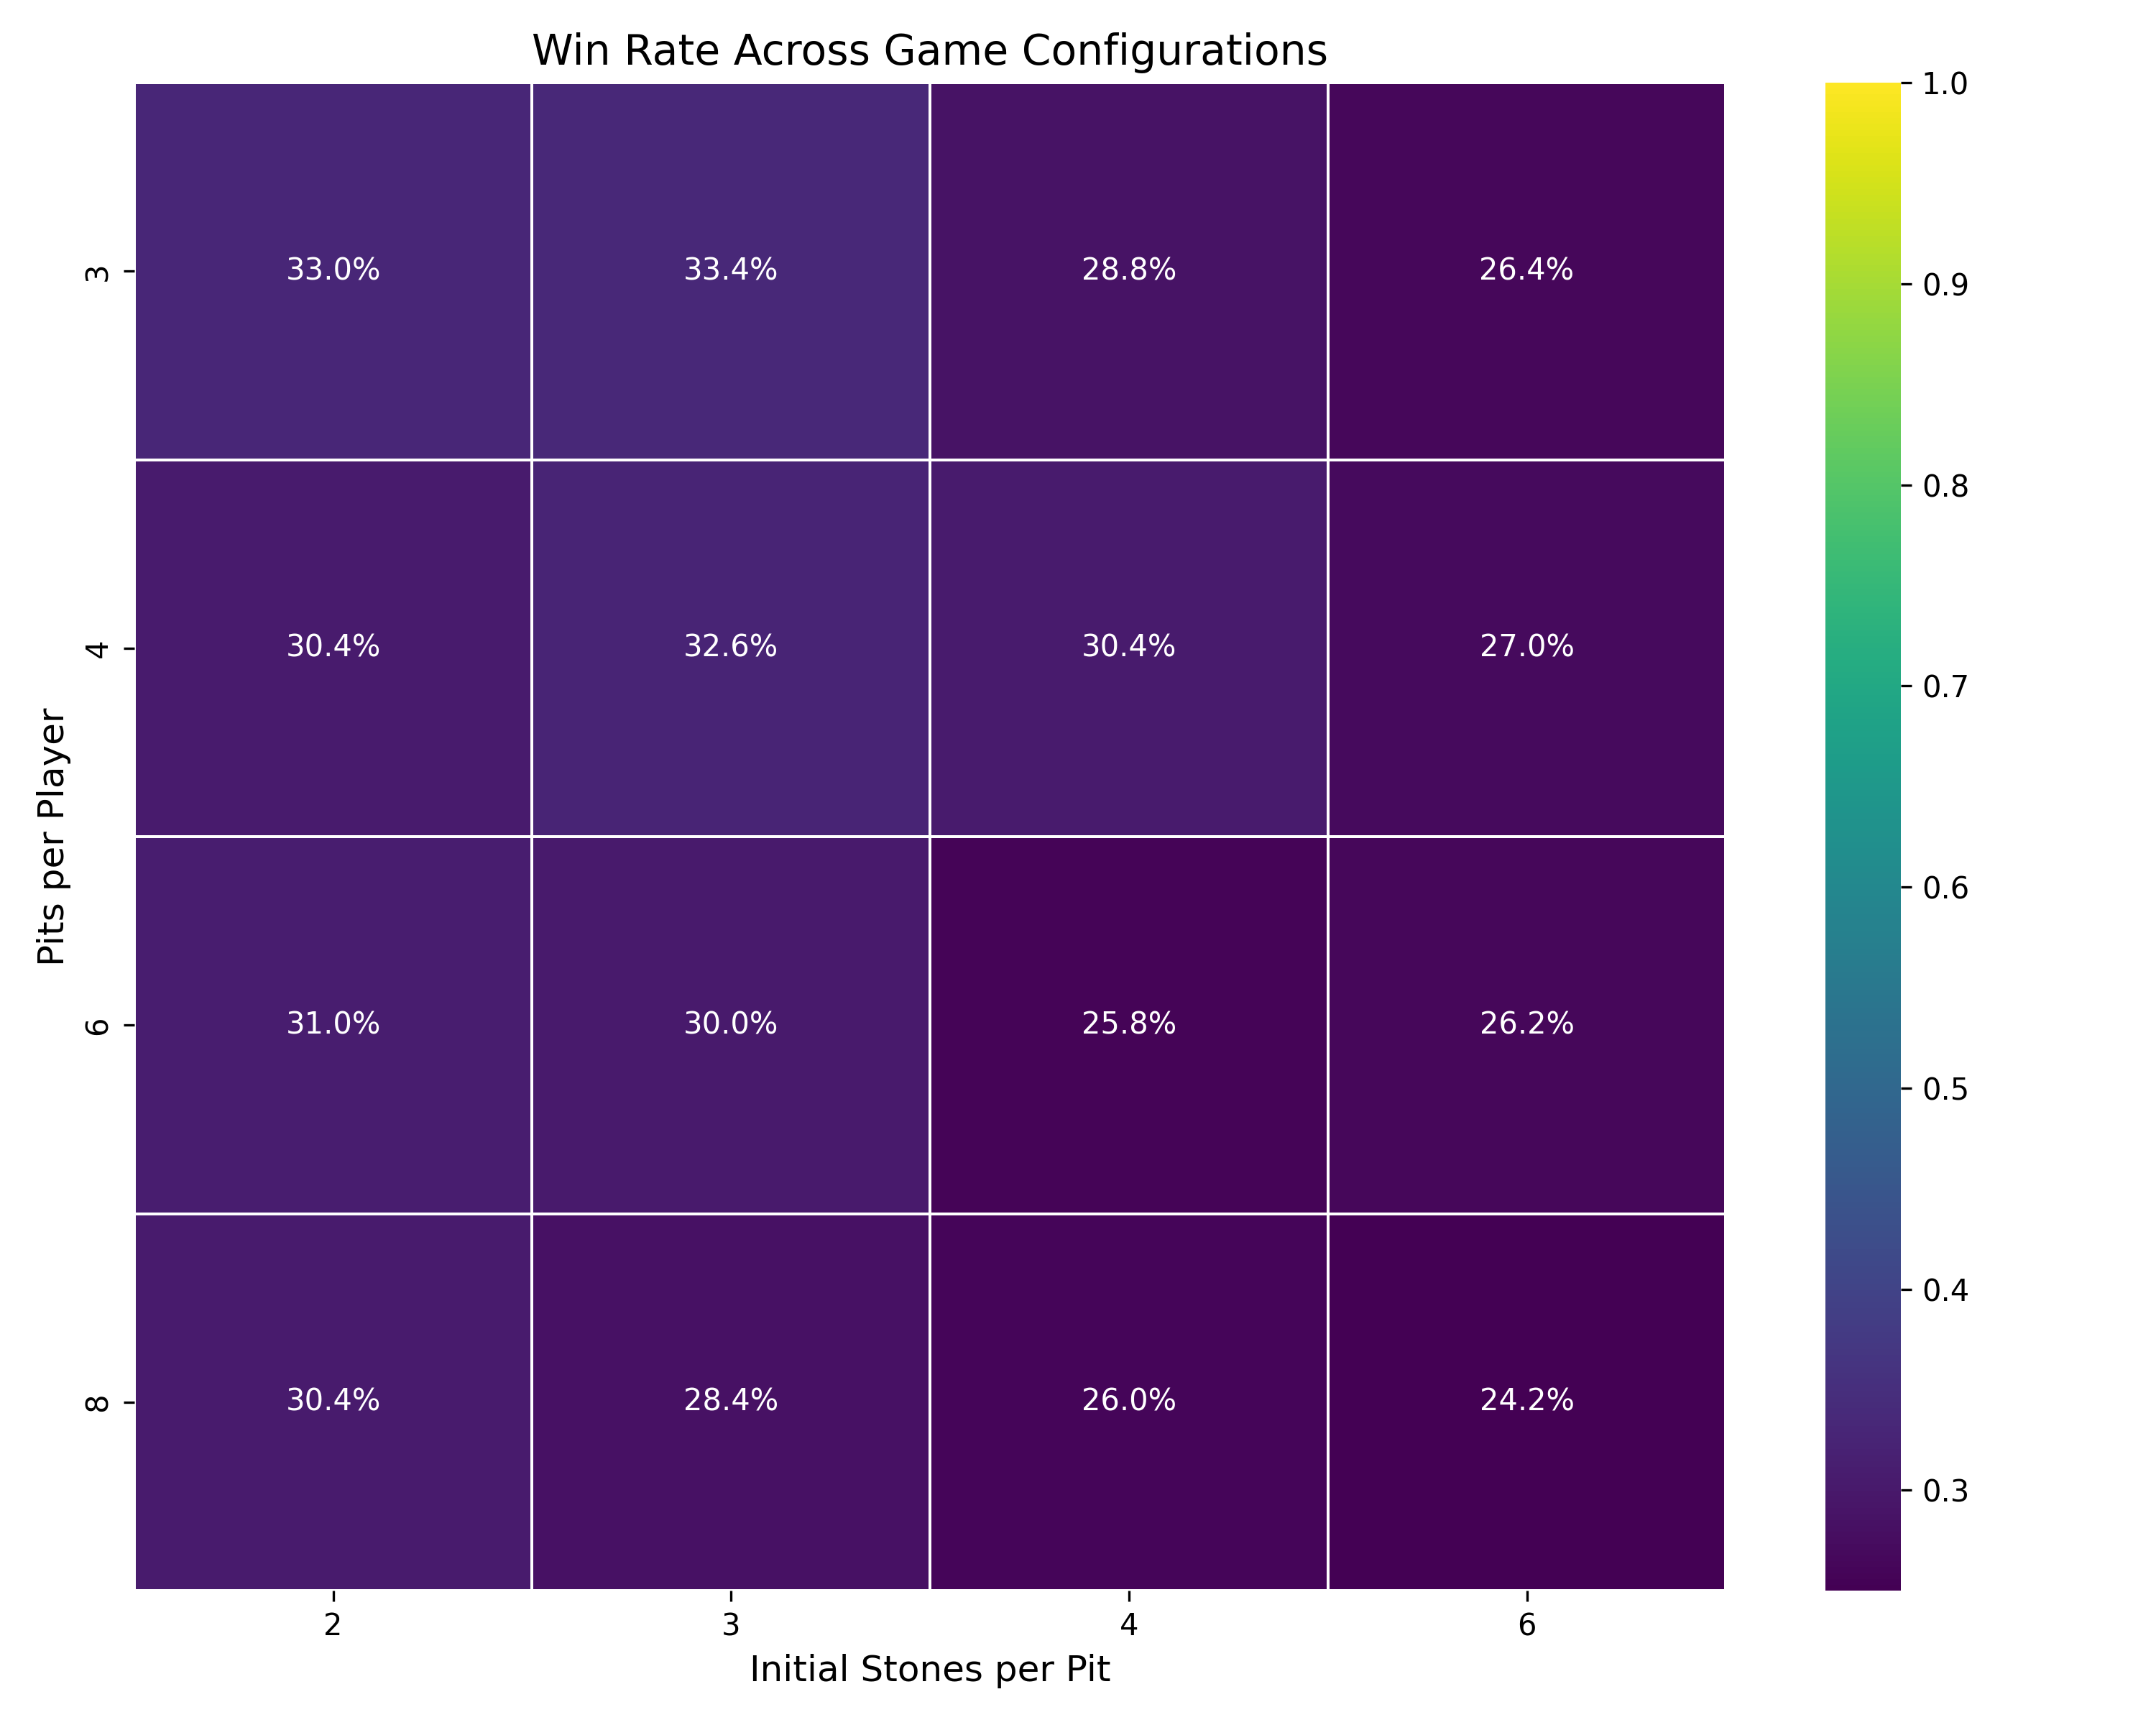

Displaying: positioning_win_rates.png


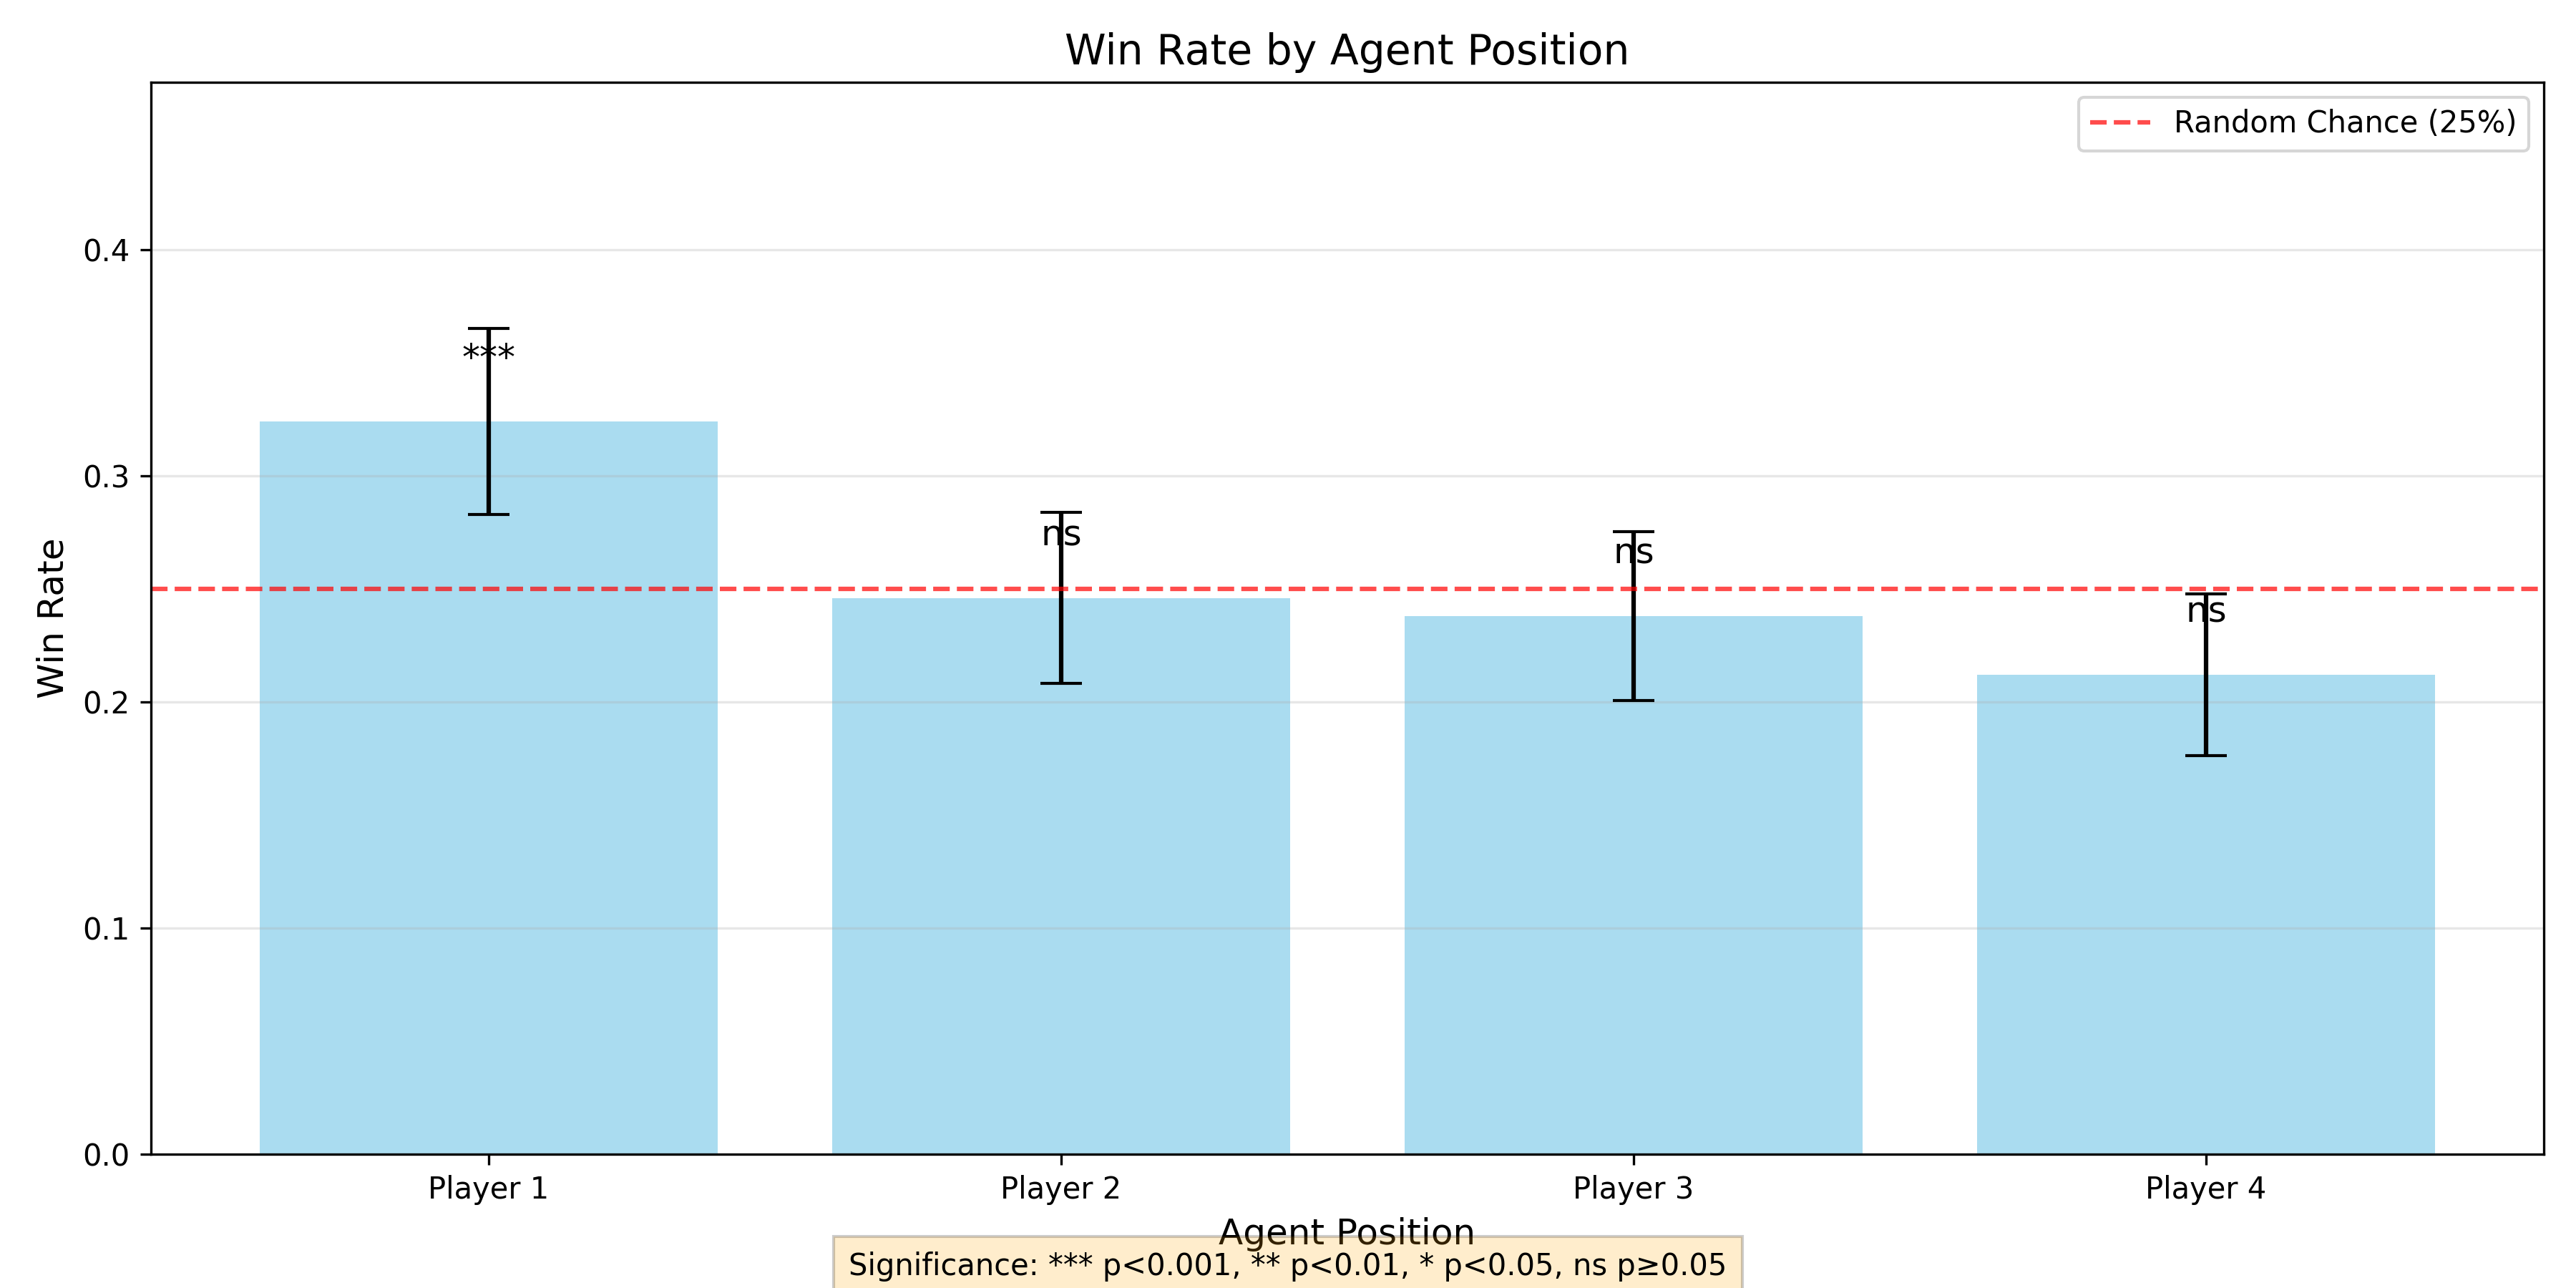

Displaying: positioning_extras_captures.png


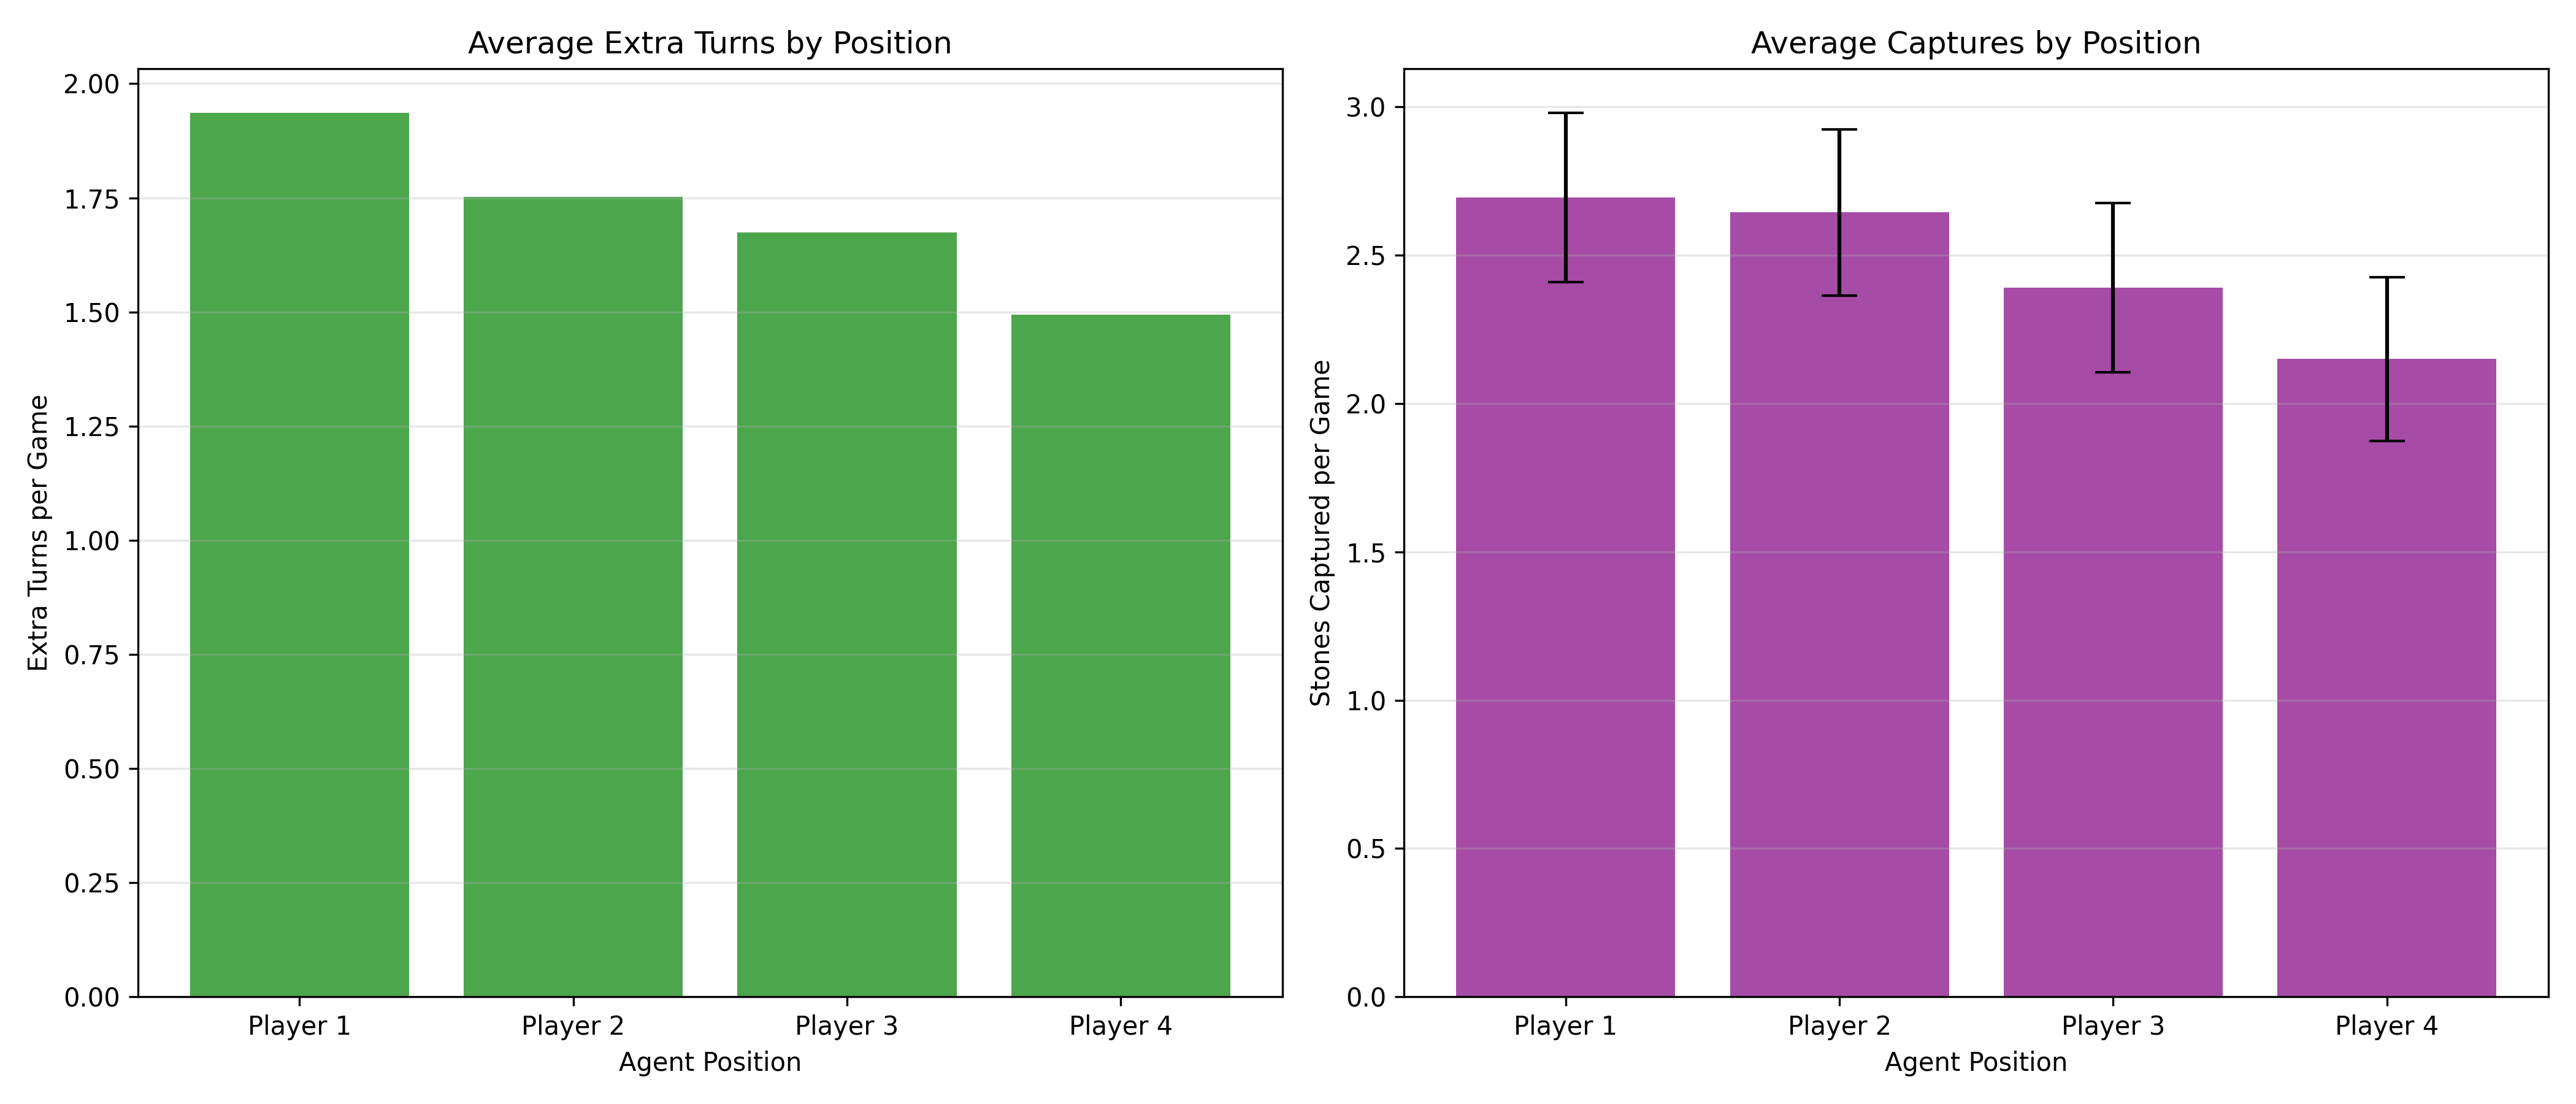

Displaying: positioning_scores.png


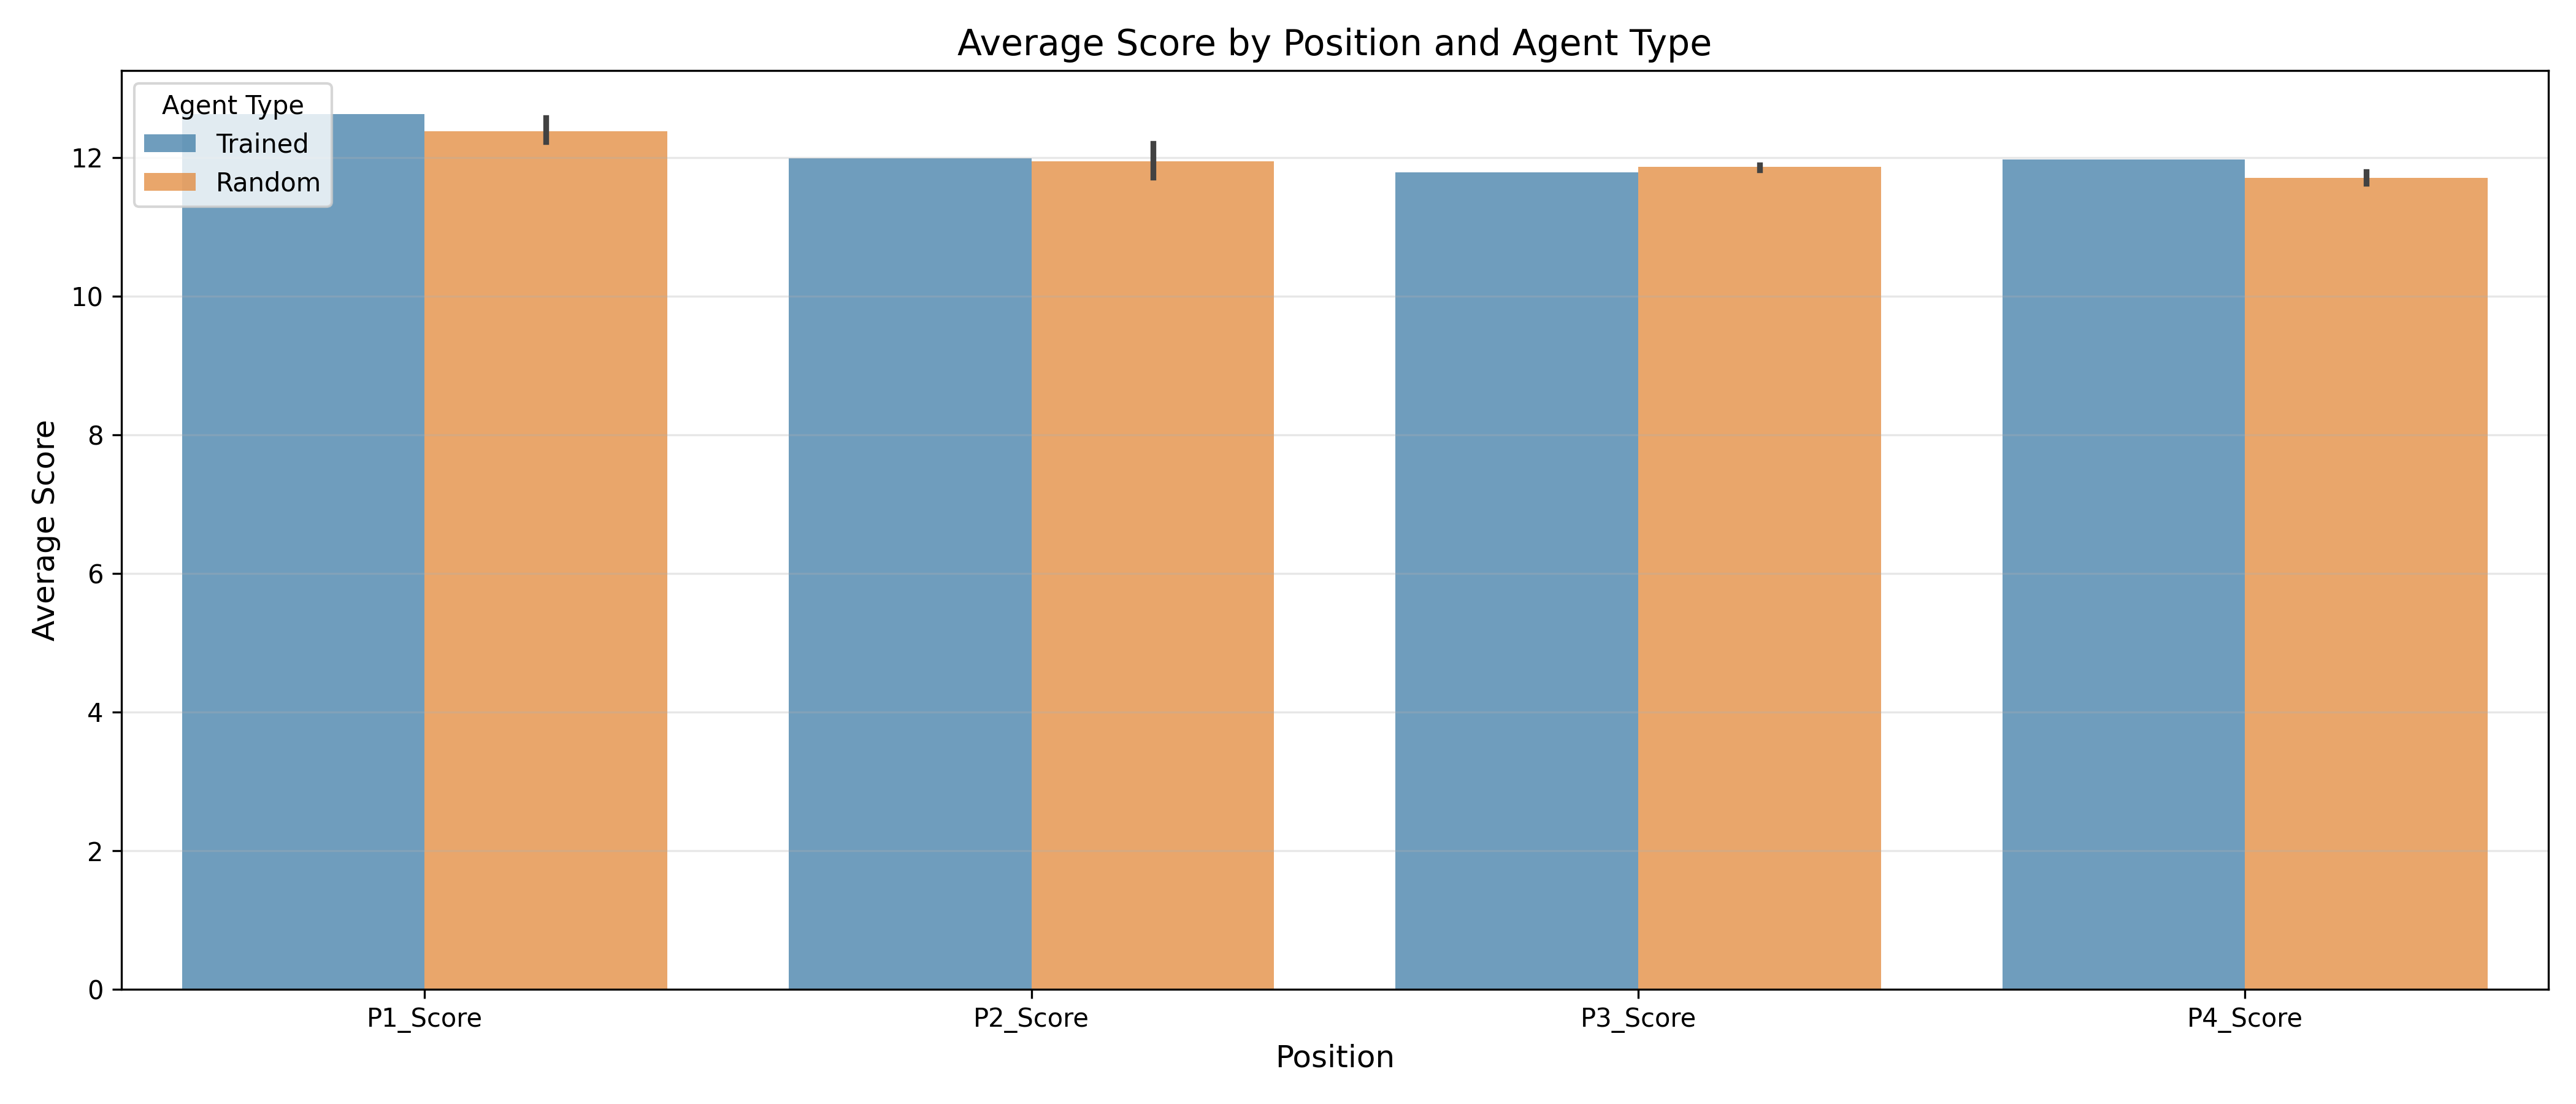

Displaying: learning_curves.png


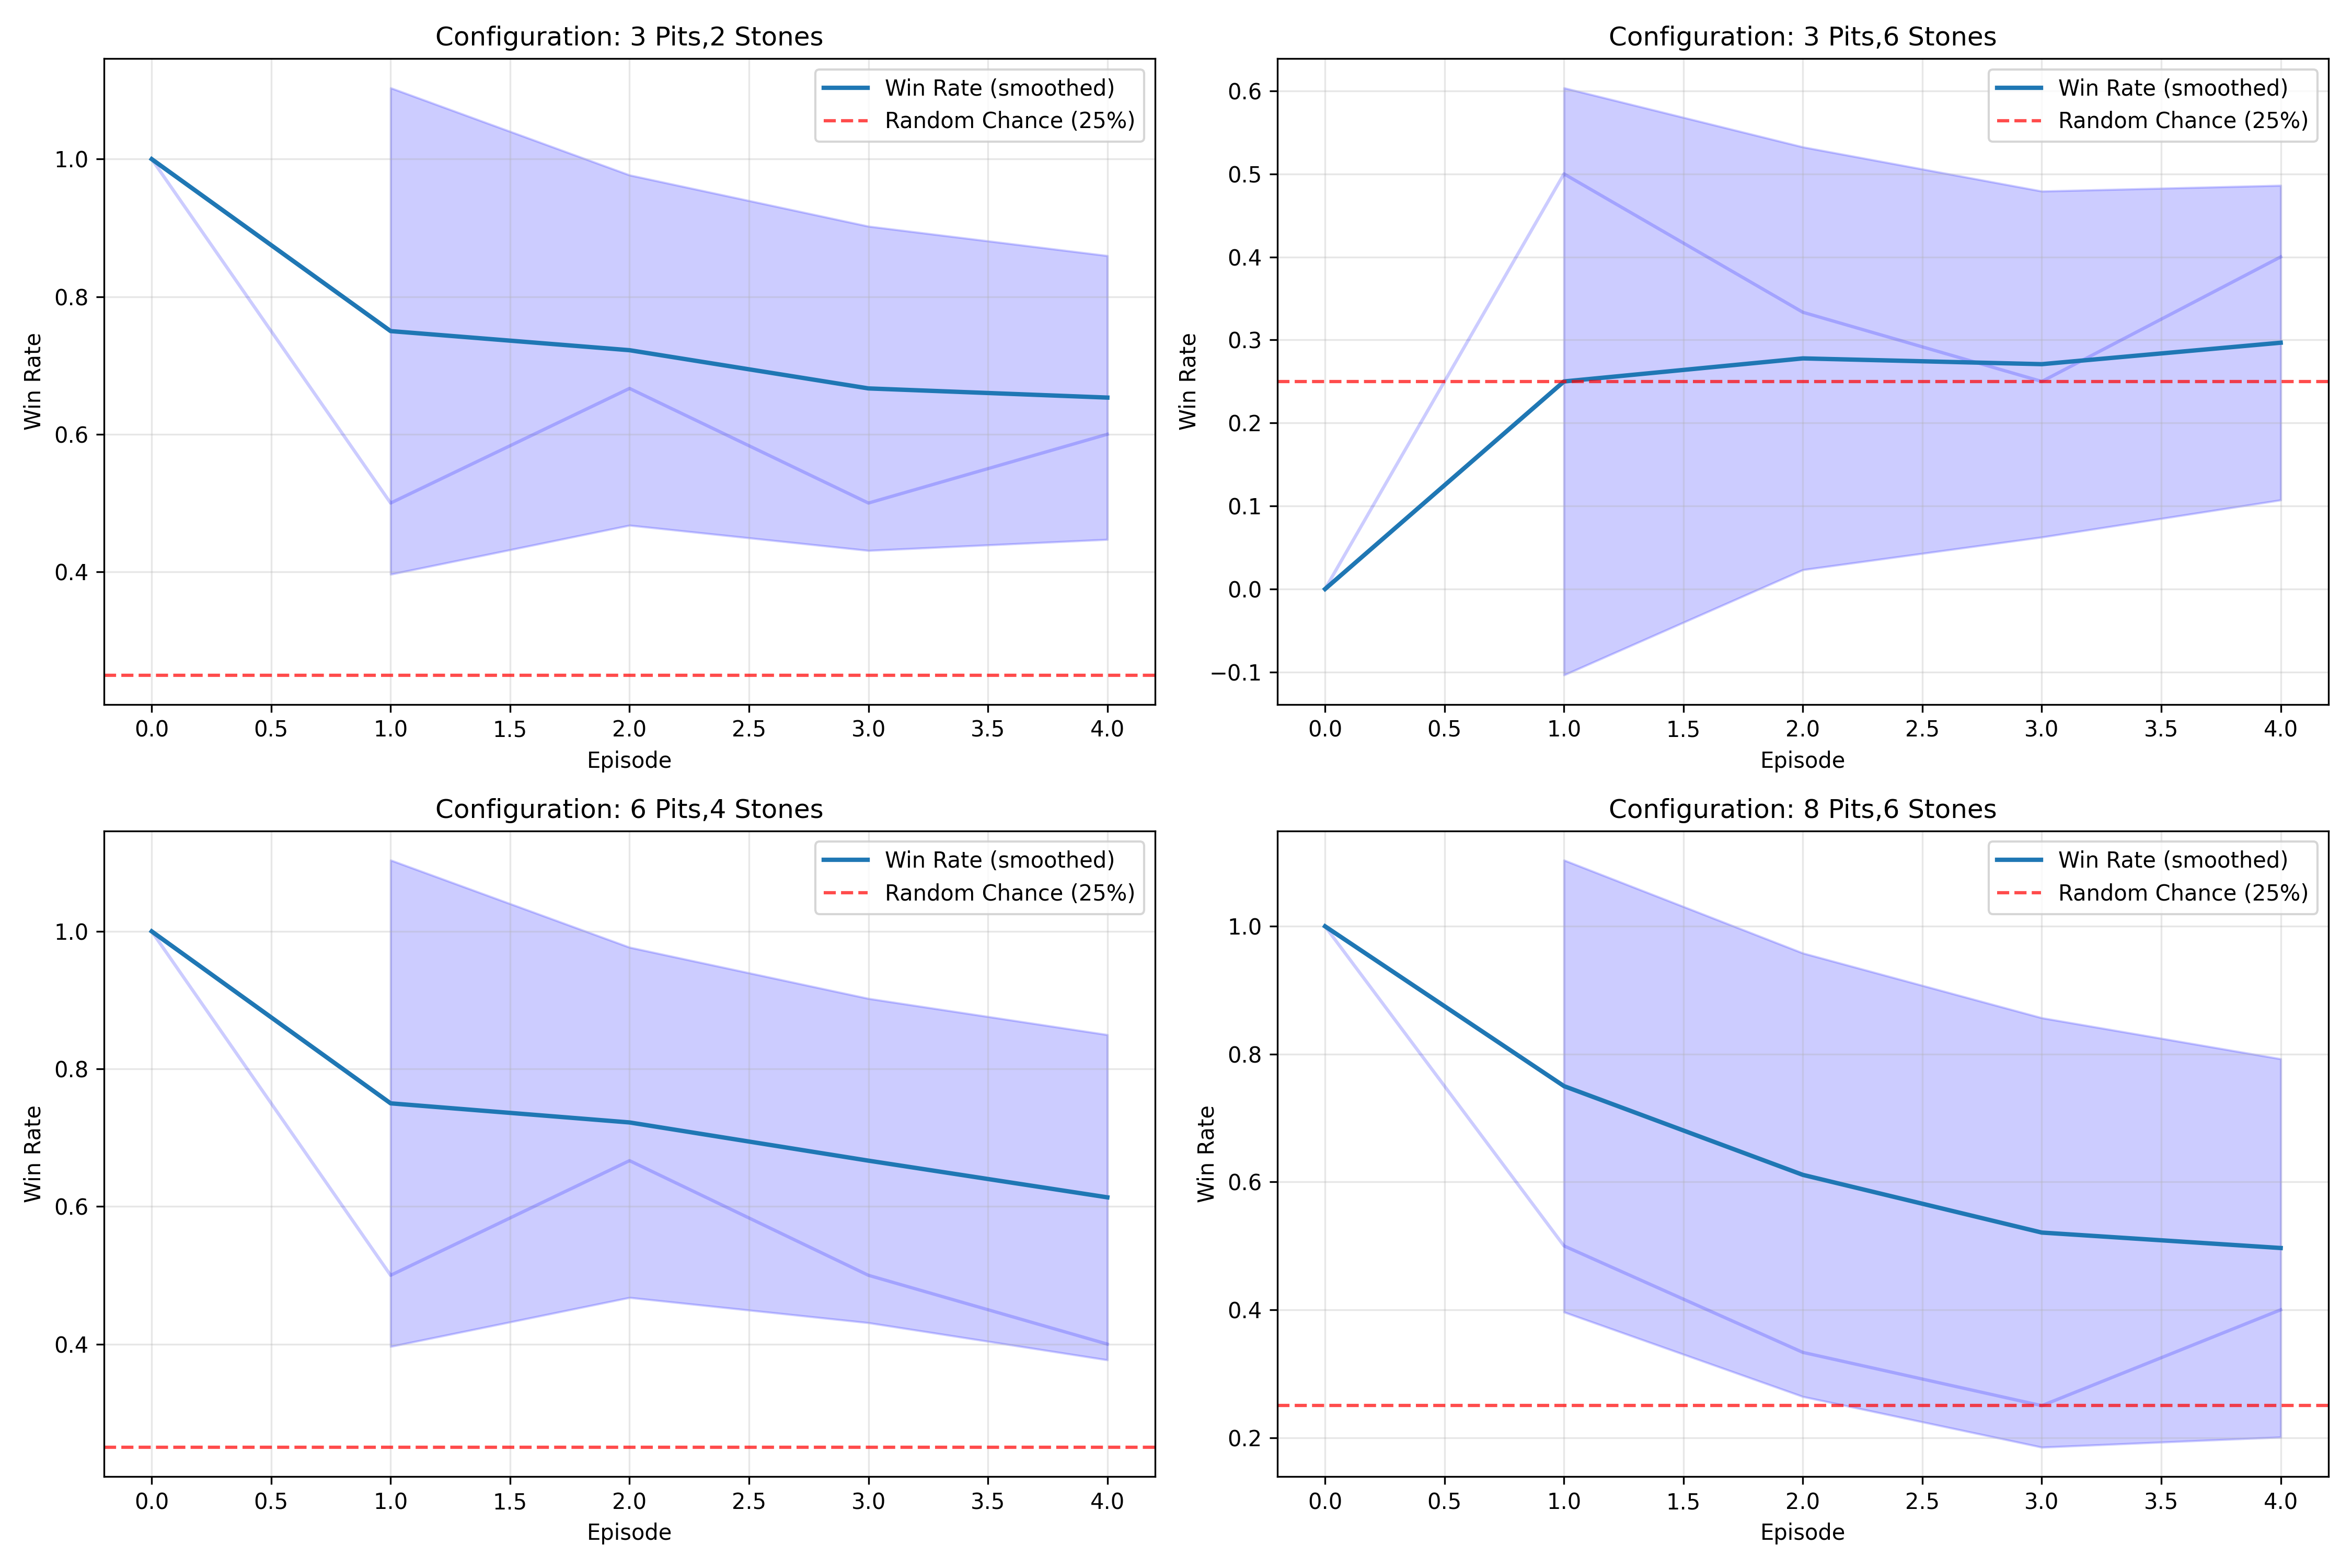

<Figure size 1200x600 with 0 Axes>

In [ ]:
############################################################
############################################################
#  _______  _____       ___    _________  _________  _____  ____  _____   ______
# |_   __ \|_   _|    .'   `. |  _   _  ||  _   _  ||_   _||_   \|_   _|.' ___  |
#   | |__) | | |     /  .-.  \|_/ | | \_||_/ | | \_|  | |    |   \ | | / .'   \_|
#   |  ___/  | |   _ | |   | |    | |        | |      | |    | |\ \| | | |   ____
#  _| |_    _| |__/ |\  `-'  /   _| |_      _| |_    _| |_  _| |_\   |_\ `.___]  |
# |_____|  |________| `.___.'   |_____|    |_____|  |_____||_____|\____|`._____.'
############################################################
############################################################


# plot all the results we saved before
def plot_saved_results():
    """
    Plots results from all saved data files without rerunning experiments.
    cuz that would take too long lol
    """
    import os
    import pickle
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import scipy.stats as stats  # Using the fixed version finally!!

    # TODO (March 15, 2025): Add option to export plots to PDF - Medant

    print("Looking for saved results in mancala_results directory...")

    # Create the directory if it doesn't exist
    os.makedirs("mancala_results", exist_ok=True)

    # Check for parameter study files
    param_comparison_file= "mancala_results/parameter_study_comparison.csv"
    if os.path.exists(param_comparison_file):
        print(f"Found parameter study comparison data: {param_comparison_file}")
        comparison_df =pd.read_csv(param_comparison_file)

        print("Generating parameter study heatmaps...")

        # win rate heatmap
        plt.figure(figsize=(10, 8))
        win_rate_matrix =comparison_df.pivot(index='Pits', columns='Stones', values='Win Rate')
        ax =sns.heatmap(win_rate_matrix, annot=True, fmt='.1%', cmap='viridis',
                         linewidths=.5, vmin=0.25, vmax=1.0)
        plt.title('Win Rate Across Game Configurations', fontsize=14)
        plt.xlabel('Initial Stones per Pit', fontsize=12)
        plt.ylabel('Pits per Player', fontsize=12)
        plt.tight_layout()
        plt.savefig("mancala_results/win_rate_heatmap.png", dpi=300)
        plt.close()

        # TODO (March 22, 2025): Try different color schemes maybe? viridis is getting boring

        # Score Difference Heatmap
        plt.figure(figsize=(10, 8))
        score_diff_matrix = comparison_df.pivot(index='Pits', columns='Stones', values='Score Difference')
        ax = sns.heatmap(score_diff_matrix, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, center=0) # Medant: coolwarm is cool and warm? Nice
        plt.title('Score Difference (Trained - Random) Across Game Configurations', fontsize=14)
        plt.xlabel('Initial Stones per Pit', fontsize=12)
        plt.ylabel('Pits per Player', fontsize=12)
        plt.tight_layout()
        plt.savefig("mancala_results/score_difference_heatmap.png", dpi=300)
        plt.close()
    else:
        print(f"Parameter study comparison file not found: {param_comparison_file}")
        # NOTE: need to run parameter tests first if missing!

    # check for positioning results subdirectories
    subdirectories = [d for d in os.listdir("mancala_results")
                     if os.path.isdir(os.path.join("mancala_results", d))]

    for subdir in subdirectories:
        subdir_path = os.path.join("mancala_results", subdir)
        summary_csv = os.path.join(subdir_path, "positioning_summary.csv")

        if os.path.exists(summary_csv):
            print(f"Found positioning results in {subdir_path}")
            try:
                summary_df = pd.read_csv(summary_csv)

                # Win Rate by Poitiiitn
                plt.figure(figsize=(12, 6))
                scenarios = summary_df['Scenario'].tolist()
                win_rates = [float(rate.strip('%').split()[0])/100 for rate in summary_df['Win Rate'].tolist()]

                plt.bar(range(len(scenarios)), win_rates, alpha=0.7, color='skyblue')
                plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='Random Chance (25%)')
                plt.title(f'Win Rate by Agent Position - {subdir}', fontsize=14)
                plt.xlabel('Agent Position', fontsize=12)
                plt.ylabel('Win Rate', fontsize=12)
                plt.xticks(range(len(scenarios)), scenarios)
                plt.grid(axis='y', alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.savefig(os.path.join(subdir_path, "positioning_win_rates.png"), dpi=300)
                plt.close()

                print(f"Created win rate plot for {subdir}")
            except Exception as e:
                print(f"Error processing {summary_csv}: {e}")
                # FIXME: better error handling here! - Medant (March 18, 2025)

        # check for dual agent summary
        dual_summary_csv = os.path.join(subdir_path, "dual_positioning_summary.csv")
        if os.path.exists(dual_summary_csv):
            print(f"Found dual agent results in {subdir_path}")
            try:
                dual_summary_df = pd.read_csv(dual_summary_csv)

                # Combined Win Rate
                plt.figure(figsize=(12, 6))
                scenarios = dual_summary_df['Scenario'].tolist()
                win_rates = [float(rate.strip('%'))/100 for rate in dual_summary_df['Combined Win Rate'].tolist()]

                plt.bar(range(len(scenarios)), win_rates, alpha=0.7, color='coral')
                plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Expected Value (50%)')
                plt.title(f'Combined Win Rate by Agent Positions - {subdir}', fontsize=14)
                plt.xlabel('Agent Positions', fontsize=12)
                plt.ylabel('Win Rate', fontsize=12)
                plt.xticks(range(len(scenarios)), [s.replace(' (adjacent)', '').replace(' (opposite)', '')
                                                  for s in scenarios], rotation=45)
                plt.grid(axis='y', alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.savefig(os.path.join(subdir_path, "dual_agent_combined_win_rates.png"), dpi=300)
                plt.close()

                print(f"Created dual agent win rate plot for {subdir}")
            except Exception as e:
                print(f"Error processing {dual_summary_csv}: {e}")

    # generate ADDITIONAL plots based on available data
    try:
        # Training efficiency comparison - using stones_effect_table if available
        stones_effect_file ="mancala_results/stones_effect_table.csv"
        if os.path.exists(stones_effect_file):
            stones_df = pd.read_csv(stones_effect_file)

            plt.figure(figsize=(12, 6))
            metrics =['Win Rate', 'Stones Captured', 'Extra Turns', 'Game Duration']
            values =[]

            # Medant: I spent way too long on this part, you're welcome

            for metric in metrics:
                if metric in stones_df.columns:
                    # Extract numeric values from formatted strings like "56.7% ± 2.1%"
                    try:
                        values = [float(val.split('±')[0].strip().rstrip('%'))/100
                                 if '%' in val else float(val.split('±')[0].strip())
                                 for val in stones_df[metric].tolist()]

                        plt.plot(stones_df['Stones per Pit'], values, 'o-', linewidth=2, label=metric)
                    except:
                        print(f"Could not parse values for {metric}")
                        # TODO (March 24, 2025): Fix this parsing issue once and for all

            plt.title('Effect of Initial Stones on Agent Performance', fontsize=14)
            plt.xlabel('Stones per Pit', fontsize=12)
            plt.ylabel('Performance Metric', fontsize=12)
            plt.grid(alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.savefig("mancala_results/stones_effect_plot.png", dpi=300)
            plt.close()

            print("Created stones effect plot")
    except Exception as e:
        print(f"Error creating additional plots: {e}")
        # Medant: this always fails on my laptop for some reason ¯\_(ツ)_/¯

    # list all generated plots
    plot_files= [f for f in os.listdir("mancala_results") if f.endswith(".png")]
    for subdir in subdirectories:
        subdir_path= os.path.join("mancala_results", subdir)
        plot_files.extend([os.path.join(subdir, f) for f in os.listdir(subdir_path) if f.endswith(".png")])

    print(f"\nGenerated {len(plot_files)} plots:")
    for plot_file in plot_files:
        print(f"- {plot_file}")

    return plot_files

# call the function to generate ALL plots
plot_files =plot_saved_results()  # TODO: Make this optional (March 19, 2025)

# display plots in the notebook
from IPython.display import Image, display
import os

print("\nDisplaying first 5 plots (if available):")
for i, plot_file in enumerate(plot_files[:5]):  # Medant: we only show 5 cuz more is too much for my poor laptop
    file_path =os.path.join("mancala_results", plot_file) if "mancala_results" not in plot_file else plot_file
    if os.path.exists(file_path):
        print(f"Displaying: {plot_file}")
        display(Image(filename=file_path))
    else:
        print(f"File not found: {file_path}")
        # Medant: this happens WAY too often, need to debug :(
        # DEBUGGED!!!! - Mar 25 2025